## HW 4
Jiachen Gong

### 1992 Paper, Size and BM Ratio
 - Load data needed
 - discussed with Yang Du

#### 1. Import

In [1]:
import os
os.getcwd()
import pandas as pd
import numpy as np
import datetime
import wrds
import pandas_datareader
from pandas.tseries.offsets import *
import time
from scipy.stats import skew

id_wrds = ''

#### 2. Download Dataset

 ##### 2.1 CSTAT 

In [3]:
########################################################################################################################
## Compustat (data from wrds)
########################################################################################################################
conn = wrds.Connection(wrds_username=id_wrds)
cstat = conn.raw_sql("""
                    select a.gvkey, a.datadate, a.at, a.pstkl, a.txditc, a.fyear, a.ceq, a.lt, 
                    a.mib, a.itcb, a.txdb, a.pstkrv, a.seq, a.pstk, b.sic, b.year1, b.naics
                    from comp.funda as a
                    left join comp.names as b
                    on a.gvkey = b.gvkey
                    where indfmt='INDL'
                    and datafmt='STD'
                    and popsrc='D'
                    and consol='C'
                    """)
conn.close()
cstat.to_pickle('.\data\cstat.pkl')
cstat

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


,gvkey,datadate,at,pstkl,txditc,fyear,ceq,lt,mib,itcb,txdb,pstkrv,seq,pstk,sic,year1,naics
0,001000,1961-12-31,NaN,0.0,0.000,1961.0,NaN,NaN,0.0,0.0,0.000,NaN,NaN,NaN,3089,1961.0,None
1,001000,1962-12-31,NaN,0.0,NaN,1962.0,0.552,NaN,0.0,NaN,NaN,NaN,NaN,0.0,3089,1961.0,None
2,001000,1963-12-31,NaN,0.0,0.008,1963.0,0.553,0.345,0.0,0.0,0.008,0.0,0.553,0.0,3089,1961.0,None
3,001000,1964-12-31,1.416,0.0,0.020,1964.0,0.607,0.809,0.0,0.0,0.020,0.0,0.607,0.0,3089,1961.0,None
4,001000,1965-12-31,2.310,0.0,0.000,1965.0,0.491,1.818,0.0,0.0,0.000,0.0,0.491,0.0,3089,1961.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71968,353742,2023-11-30,261.713,0.0,8.084,2023.0,245.192,16.521,0.0,0.0,8.084,0.0,245.192,0.0,1400,2021.0,212390
71969,353945,2022-12-31,981.551,0.0,32.811,2022.0,283.784,685.045,0.0,0.0,32.811,0.0,283.784,0.0,3621,2021.0,335312
71970,354003,2023-12-31,NaN,NaN,NaN,2023.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6722,2023.0,525910
71971,356128,2022-12-31,11072.847,0.0,7.016,2022.0,1771.010,9287.732,0.0,0.0,7.016,0.0,1771.010,0.0,6141,2022.0,522291


##### 2.2 Pension

In [4]:
# Pension data
conn = wrds.Connection(wrds_username=id_wrds)
Pension = conn.raw_sql("""
                        select gvkey, datadate, prba
                        from comp.aco_pnfnda
                        where indfmt='INDL'
                        and datafmt='STD'
                        and popsrc='D'
                        and consol='C'
                        """)
conn.close()
Pension.to_pickle('.\data\Pension.pkl')
Pension

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


,gvkey,datadate,prba
0,001000,1973-12-31,NaN
1,001000,1974-12-31,NaN
2,001000,1975-12-31,NaN
3,001000,1976-12-31,NaN
4,001000,1977-12-31,NaN
...,...,...,...
150733,351590,2023-12-31,-620.099
150734,353444,2021-12-31,-135.410
150735,353444,2022-12-31,-101.212
150736,353444,2023-12-31,-108.273


##### 2.3 LinkedTable

In [5]:
########################################################################################################################
## CRSP-Compustat link table (data from wrds)
########################################################################################################################
conn = wrds.Connection(wrds_username=id_wrds)
crsp_cstat=conn.raw_sql("""
                  select gvkey, lpermno as permno, lpermco as permco, linktype, linkprim, liid,
                  linkdt, linkenddt
                  from crspq.ccmxpf_linktable
                  where substr(linktype,1,1)='L'
                  and (linkprim ='C' or linkprim='P')
                  """)
conn.close()
crsp_cstat.to_pickle('.\data\crsp_cstat.pkl')
crsp_cstat

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


,gvkey,permno,permco,linktype,linkprim,liid,linkdt,linkenddt
0,001000,25881.0,23369.0,LU,P,01,1970-11-13,1978-06-30
1,001001,10015.0,6398.0,LU,P,01,1983-09-20,1986-07-31
2,001002,10023.0,22159.0,LC,C,01,1972-12-14,1973-06-05
3,001003,10031.0,6672.0,LU,C,01,1983-12-07,1989-08-16
4,001004,54594.0,20000.0,LU,P,01,1972-04-24,None
...,...,...,...,...,...,...,...,...
38285,351038,16161.0,55612.0,LC,P,90,2021-10-29,None
38286,352262,23773.0,59507.0,LC,P,01,2023-03-17,None
38287,353444,23209.0,59330.0,LC,P,90,2022-07-22,None
38288,354003,23698.0,37493.0,LS,P,01,2023-02-24,None


##### 2.4 CRSP Return

In [6]:
########################################################################################################################
## CRSP returns (data from wrds)
########################################################################################################################
conn = wrds.Connection(wrds_username=id_wrds)
crsp_raw = conn.raw_sql("""
                      select a.permno, a.permco, a.date,b.shrcd, b.exchcd, b.siccd, b.naics,
                      a.ret, a.retx, a.shrout, a.prc
                      from crspq.msf as a
                      left join crspq.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where b.shrcd in (10,11)
                      and b.exchcd in (1,2,3)
                      """)
conn.close()
crsp_raw[['permno','permco']] = crsp_raw[['permno','permco']].astype(int)
crsp_raw['date'] = pd.to_datetime(crsp_raw['date'],format = "%Y-%m-%d",errors = 'ignore')+MonthEnd(0)
crsp_raw.to_pickle('.\data\crsp_raw.pkl')
crsp_raw

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


,permno,permco,date,shrcd,exchcd,siccd,naics,ret,retx,shrout,prc
0,10000,7952,1986-01-31,10,3,3990,None,NaN,NaN,3680.0,-4.37500
1,10000,7952,1986-02-28,10,3,3990,None,-0.257143,-0.257143,3680.0,-3.25000
2,10000,7952,1986-03-31,10,3,3990,None,0.365385,0.365385,3680.0,-4.43750
3,10000,7952,1986-04-30,10,3,3990,None,-0.098592,-0.098592,3793.0,-4.00000
4,10000,7952,1986-05-31,10,3,3990,None,-0.222656,-0.222656,3793.0,-3.10938
...,...,...,...,...,...,...,...,...,...,...,...
272178,93436,53453,2023-11-30,11,3,9999,336110,0.195379,0.195379,3178921.0,240.08000
272179,93436,53453,2023-12-31,11,3,9999,336110,0.034988,0.034988,3185000.0,248.48000
272180,93436,53453,2024-01-31,11,3,9999,336110,-0.246257,-0.246257,3184790.0,187.28999
272181,93436,53453,2024-02-29,11,3,9999,336110,0.077901,0.077901,3184790.0,201.88000


##### 2.5 CRSP delisted

In [7]:
# Load CRSP Deslisting returns
conn = wrds.Connection(wrds_username=id_wrds)
dlret_raw = conn.raw_sql("""
                        select a.permno, a.permco, a.dlret, a.dlretx, a.dlstdt, 
                        b.exchcd as dlexchcd, b.siccd as dlsiccd, b.naics as dlnaics
                        from crspq.msedelist as a
                        left join crspq.msenames as b
                        on a.permno=b.permno
                        and b.namedt<=a.dlstdt
                        and a.dlstdt<=b.nameendt
                        where b.shrcd in (10,11)
                        and b.exchcd in (1,2,3)
                        """) 
conn.close()
dlret_raw['dlstdt'] = pd.to_datetime(dlret_raw['dlstdt'])
dlret_raw['date'] = dlret_raw['dlstdt']+MonthEnd(0)
dlret_raw.to_pickle('.\data\dlret_raw.pkl')
dlret_raw


WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


,permno,permco,dlret,dlretx,dlstdt,dlexchcd,dlsiccd,dlnaics,date
0,10000,7952,0.000000,0.000000,1987-06-11,3,3990,None,1987-06-30
1,10001,7953,0.011583,0.011583,2017-08-03,2,4925,221210,2017-08-31
2,10002,7954,0.046007,0.046007,2013-02-15,3,6020,551111,2013-02-28
3,10003,7957,0.013730,0.013730,1995-12-15,3,6020,None,1995-12-31
4,10005,7961,0.125000,0.125000,1991-07-11,3,1310,None,1991-07-31
...,...,...,...,...,...,...,...,...,...
26474,93432,53450,-0.827922,-0.827922,2011-05-31,3,7389,541870,2011-05-31
26475,93433,53451,-0.127273,-0.127273,2016-12-22,3,9999,511210,2016-12-31
26476,93434,53427,NaN,NaN,2024-03-28,3,9999,111998,2024-03-31
26477,93435,53452,-0.778409,-0.778409,2012-05-18,3,6163,522310,2012-05-31


##### 2.6 FF 3 factor

In [8]:
# Fama and French 3 Factors
# pd.set_option('precision', 2)
data2 = pandas_datareader.famafrench.FamaFrenchReader('F-F_Research_Data_Factors',start='1900', end=str(datetime.datetime.now().year+1))
french = data2.read()[0] / 100 # Monthly data
french['Mkt'] = french['Mkt-RF'] + french['RF']

# Book-to-Market Portfolios
data2 = pandas_datareader.famafrench.FamaFrenchReader('Portfolios_Formed_on_BE-ME',start='1900', end=str(datetime.datetime.now().year+1))
data2 = data2.read()[0][['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9', 'Hi 10']] / 100
data2.columns = 'BM01','BM02','BM03','BM04','BM05','BM06','BM07','BM08','BM09','BM10'
french = pd.merge(french,data2,how='left',on=['Date'])

# Size Portfolios
data2 = pandas_datareader.famafrench.FamaFrenchReader('Portfolios_Formed_on_ME',start='1900', end=str(datetime.datetime.now().year+1))
data2 = data2.read()[0][['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9', 'Hi 10']] / 100
data2.columns = 'ME01','ME02','ME03','ME04','ME05','ME06','ME07','ME08','ME09','ME10'
french = pd.merge(french,data2,how='left',on=['Date'])

# 25 Book-to-Market and Size Portfolios
data2 = pandas_datareader.famafrench.FamaFrenchReader('25_Portfolios_5x5',start='1900', end=str(datetime.datetime.now().year+1))
data2 = data2.read()[0].rename(columns={"SMALL LoBM":"ME1 BM1","SMALL HiBM":"ME1 BM5","BIG LoBM":"ME5 BM1","BIG HiBM":"ME5 BM5"}) / 100
french = pd.merge(french,data2,how='left',on=['Date'])

# Changing date format and save
french = french.reset_index().rename(columns={"Date":"date"})
french['date'] = pd.DataFrame(french[['date']].values.astype('datetime64[ns]')) + MonthEnd(0)
print('Data from Ken French Website:')
print(french.columns)
french.to_pickle('.\data\\franch.pkl')
french

C:\Users\14561\AppData\Local\Temp\ipykernel_28748\3238560411.py:4: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  french = data2.read()[0] / 100 # Monthly data
C:\Users\14561\AppData\Local\Temp\ipykernel_28748\3238560411.py:4: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  french = data2.read()[0] / 100 # Monthly data
C:\Users\14561\AppData\Local\Temp\ipykernel_28748\3238560411.py:9: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data2 = data2.read()[0][['Lo 10', 'Dec 2', 'Dec 3', 'Dec 4', 'Dec 5', 'Dec 6', 'Dec 7', 'Dec 8', 'Dec 9'

Data from Ken French Website:
Index(['date', 'Mkt-RF', 'SMB', 'HML', 'RF', 'Mkt', 'BM01', 'BM02', 'BM03',
       'BM04', 'BM05', 'BM06', 'BM07', 'BM08', 'BM09', 'BM10', 'ME01', 'ME02',
       'ME03', 'ME04', 'ME05', 'ME06', 'ME07', 'ME08', 'ME09', 'ME10',
       'ME1 BM1', 'ME1 BM2', 'ME1 BM3', 'ME1 BM4', 'ME1 BM5', 'ME2 BM1',
       'ME2 BM2', 'ME2 BM3', 'ME2 BM4', 'ME2 BM5', 'ME3 BM1', 'ME3 BM2',
       'ME3 BM3', 'ME3 BM4', 'ME3 BM5', 'ME4 BM1', 'ME4 BM2', 'ME4 BM3',
       'ME4 BM4', 'ME4 BM5', 'ME5 BM1', 'ME5 BM2', 'ME5 BM3', 'ME5 BM4',
       'ME5 BM5'],
      dtype='object')


,date,Mkt-RF,SMB,HML,RF,Mkt,BM01,BM02,BM03,BM04,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,ME5 BM1,ME5 BM2,ME5 BM3,ME5 BM4,ME5 BM5
0,1926-07-31,0.0296,-0.0256,-0.0243,0.0022,0.0318,0.0463,0.0122,0.1138,0.0168,...,0.015893,0.015278,0.012978,0.002727,0.024678,0.034539,0.060902,0.020266,0.031111,0.005623
1,1926-08-31,0.0264,-0.0117,0.0382,0.0025,0.0289,0.0015,0.0219,0.0639,0.0238,...,0.013336,0.038730,0.020021,0.021706,0.053422,0.010124,0.041903,0.020131,0.054849,0.077576
2,1926-09-30,0.0036,-0.0140,0.0013,0.0023,0.0059,-0.0011,-0.0232,0.0630,0.0073,...,0.010923,-0.005250,-0.017636,0.014646,0.008730,-0.012906,0.036538,0.000950,-0.007487,-0.024284
3,1926-10-31,-0.0324,-0.0009,0.0070,0.0032,-0.0292,-0.0378,-0.0167,-0.0501,-0.0141,...,-0.033361,-0.026559,-0.021070,-0.031051,-0.053525,-0.027413,-0.030071,-0.022437,-0.046719,-0.058129
4,1926-11-30,0.0253,-0.0010,-0.0051,0.0031,0.0284,0.0603,0.0151,0.0110,0.0363,...,0.034448,0.023887,0.037335,0.049320,0.018213,0.042946,0.025326,0.015204,0.036619,0.025636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,2023-11-30,0.0884,-0.0002,0.0164,0.0044,0.0928,0.1108,0.0758,0.0757,0.0714,...,0.098743,0.089790,0.095279,0.087238,0.078476,0.098946,0.070176,0.070932,0.086614,0.152510
1169,2023-12-31,0.0487,0.0634,0.0493,0.0043,0.0530,0.0363,0.0507,0.0586,0.0590,...,0.086568,0.077652,0.091821,0.090094,0.117210,0.037289,0.047129,0.050839,0.046592,0.116076
1170,2024-01-31,0.0071,-0.0509,-0.0238,0.0047,0.0118,0.0229,0.0128,-0.0023,-0.0176,...,-0.016845,0.000094,-0.015281,-0.032800,-0.024467,0.022795,-0.005613,0.035883,0.026630,-0.008891
1171,2024-02-29,0.0506,-0.0024,-0.0349,0.0042,0.0548,0.0592,0.0646,0.0252,0.0425,...,0.071411,0.080950,0.033699,0.046102,0.025429,0.060660,0.016357,0.080426,0.049935,0.029089


Now all the data has been downloaded.

#### 3. Clean CRSP Data
##### 3.1 Merge CRSP delisting data

In [46]:
crsp_raw = pd.read_pickle('.\data\crsp_raw.pkl')
dlret_raw = pd.read_pickle('.\data\dlret_raw.pkl')

# merge dlret into ret
crsp = crsp_raw.merge(dlret_raw[['permno','dlret','date']], on=['permno','date'],how = 'outer')

crsp = crsp[(crsp['exchcd'].isin([1,2,3])) & (crsp['shrcd'].isin([10,11]))]
# merge dlret and fix ret
# if ret and dlret both exist
crsp['ret'] = np.where(crsp['ret'].notna() & crsp['dlret'].notna(),(1+crsp['ret'])*(1+crsp['dlret'])-1, crsp['ret'])
# if only one value exist
crsp['ret'] = np.where(crsp['ret'].isna()  & crsp['dlret'].notna(), crsp['dlret'], crsp['ret'])
# if both na
crsp['ret'] = np.where(crsp['ret'].isna() & crsp['dlret'].isna(),0,crsp['ret'])
# crsp['date'] = pd.to_datetime(crsp['date'])
# crsp['Year'] = crsp['date'].dt.year
# crsp['Month'] = crsp['date'].dt.month
# crsp.to_pickle('.\data\crsp_clean.pkl')
crsp


,permno,permco,date,shrcd,exchcd,siccd,naics,ret,retx,shrout,prc,dlret
0,10000,7952.0,1986-01-31,10.0,3.0,3990.0,None,0.000000,NaN,3680.0,-4.37500,NaN
1,10000,7952.0,1986-02-28,10.0,3.0,3990.0,None,-0.257143,-0.257143,3680.0,-3.25000,NaN
2,10000,7952.0,1986-03-31,10.0,3.0,3990.0,None,0.365385,0.365385,3680.0,-4.43750,NaN
3,10000,7952.0,1986-04-30,10.0,3.0,3990.0,None,-0.098592,-0.098592,3793.0,-4.00000,NaN
4,10000,7952.0,1986-05-31,10.0,3.0,3990.0,None,-0.222656,-0.222656,3793.0,-3.10938,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3772178,93436,53453.0,2023-11-30,11.0,3.0,9999.0,336110,0.195379,0.195379,3178921.0,240.08000,NaN
3772179,93436,53453.0,2023-12-31,11.0,3.0,9999.0,336110,0.034988,0.034988,3185000.0,248.48000,NaN
3772180,93436,53453.0,2024-01-31,11.0,3.0,9999.0,336110,-0.246257,-0.246257,3184790.0,187.28999,NaN
3772181,93436,53453.0,2024-02-29,11.0,3.0,9999.0,336110,0.077901,0.077901,3184790.0,201.88000,NaN


##### 3.2 Link gvkey
merge gvkey using link table

In [47]:
LinkTable = pd.read_pickle('.\data\crsp_cstat.pkl')

# Step 1: merge all links
crsp = crsp.sort_values(['permco','permno','date']).reset_index(drop=True).copy()
crsp_linktable = crsp.merge(LinkTable, on=['permno','permco'], how='inner')
numdup = np.sum(crsp_linktable[['permno', 'date']].duplicated(keep='first'))
print('Step 1: Number of Link Duplicates after merging: ' + str(numdup))

# Step 2: restrict to valid links
crsp_linktable = crsp_linktable[(crsp_linktable['linkdt'].isna() | (crsp_linktable['date'] >= crsp_linktable['linkdt'])) & (crsp_linktable['linkenddt'].isna() | (crsp_linktable['date'] <= crsp_linktable['linkenddt']))].copy()
crsp_linktable = crsp_linktable.sort_values(by=['permno', 'date']).reset_index(drop=True).copy()
numdup = np.sum(crsp_linktable[['permno', 'date']].duplicated(keep='first'))
print('After Step 2 (valid links): Number of Link Duplicates: ' + str(numdup))

# Step 3: if LC not LC linktype, only keep LC (LC stands for "Link research complete. Standard connection between databases.")
crsp_linktable['keep'] = True
crsp_linktable['flag'] = np.where(crsp_linktable['linktype'] == 'LC', 1, 0)  # Link research complete. Standard connection between databases.
crsp_linktable = crsp_linktable.merge(crsp_linktable[['permno', 'date', 'flag']].groupby(['permno', 'date']).sum().reset_index().rename(columns={'flag': 'ct_flag'}),on=['permno', 'date'], how='left')
crsp_linktable.loc[crsp_linktable[['permno', 'date']].duplicated(keep=False) & (crsp_linktable['ct_flag'] >= 1) & (crsp_linktable['flag'] == 0), 'keep'] = False
crsp_linktable = crsp_linktable[crsp_linktable['keep']].copy()
crsp_linktable.drop(['keep', 'flag', 'ct_flag'], axis=1, inplace=True)
numdup = np.sum(crsp_linktable[['permno', 'date']].duplicated(keep='first'))
print('After Step 3 (keep linktype=LC): Number of Link Duplicates: ' + str(numdup))

# Step 4: if P and not P linkprim, only keep P
crsp_linktable['keep'] = True
crsp_linktable['flag'] = np.where((crsp_linktable['linkprim'] == 'P'), 1, 0)  # Primary Link Marker: "P" indicates a primary link marker, as identified by Compustat in monthly security data.
crsp_linktable = crsp_linktable.merge(crsp_linktable[['permno', 'date', 'flag']].groupby(['permno', 'date']).sum().reset_index().rename(columns={'flag': 'ct_flag'}),on=['permno', 'date'], how='left')
crsp_linktable.loc[crsp_linktable[['permno', 'date']].duplicated(keep=False) & (crsp_linktable['ct_flag'] >= 1) & (crsp_linktable['flag'] == 0), 'keep'] = False
crsp_linktable = crsp_linktable[crsp_linktable['keep']].copy()
crsp_linktable.drop(['keep', 'flag', 'ct_flag'], axis=1, inplace=True)
numdup = np.sum(crsp_linktable[['permno', 'date']].duplicated(keep='first'))
print('After Step 4 (keep keeep linkprim=P): Number of Link Duplicates: ' + str(numdup))

crsp_linktable['date'] = pd.to_datetime(crsp_linktable['date'])
crsp_linktable['Year'] = crsp_linktable['date'].dt.year
crsp_linktable['Month'] = crsp_linktable['date'].dt.month

# Dropping linktable variable that are no longer needed
crsp_linktable.drop(axis=1,columns=['linktype','linkprim','liid','linkdt','linkenddt'], inplace=True)
crsp_linktable.to_pickle('.\data\crsp_linkedtable.pkl')
crsp_linktable


Step 1: Number of Link Duplicates after merging: 995053
After Step 2 (valid links): Number of Link Duplicates: 6670
After Step 3 (keep linktype=LC): Number of Link Duplicates: 45
After Step 4 (keep keeep linkprim=P): Number of Link Duplicates: 0


,permno,permco,date,shrcd,exchcd,siccd,naics,ret,retx,shrout,prc,dlret,gvkey,Year,Month
0,10000,7952.0,1986-01-31,10.0,3.0,3990.0,None,0.000000,NaN,3680.0,-4.37500,NaN,013007,1986,1
1,10000,7952.0,1986-02-28,10.0,3.0,3990.0,None,-0.257143,-0.257143,3680.0,-3.25000,NaN,013007,1986,2
2,10000,7952.0,1986-03-31,10.0,3.0,3990.0,None,0.365385,0.365385,3680.0,-4.43750,NaN,013007,1986,3
3,10000,7952.0,1986-04-30,10.0,3.0,3990.0,None,-0.098592,-0.098592,3793.0,-4.00000,NaN,013007,1986,4
4,10000,7952.0,1986-05-31,10.0,3.0,3990.0,None,-0.222656,-0.222656,3793.0,-3.10938,NaN,013007,1986,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3250720,93436,53453.0,2023-11-30,11.0,3.0,9999.0,336110,0.195379,0.195379,3178921.0,240.08000,NaN,184996,2023,11
3250721,93436,53453.0,2023-12-31,11.0,3.0,9999.0,336110,0.034988,0.034988,3185000.0,248.48000,NaN,184996,2023,12
3250722,93436,53453.0,2024-01-31,11.0,3.0,9999.0,336110,-0.246257,-0.246257,3184790.0,187.28999,NaN,184996,2024,1
3250723,93436,53453.0,2024-02-29,11.0,3.0,9999.0,336110,0.077901,0.077901,3184790.0,201.88000,NaN,184996,2024,2


#### 4. Calculate BE
##### 4.1 clean the BE data

In [48]:
# merge Pension
cstat = pd.read_pickle('.\data\cstat.pkl')
Pension = pd.read_pickle('.\data\Pension.pkl')
cstat = cstat.merge(Pension, on = ['gvkey','datadate'],how = 'outer')
cstat

,gvkey,datadate,at,pstkl,txditc,fyear,ceq,lt,mib,itcb,txdb,pstkrv,seq,pstk,sic,year1,naics,prba
0,001000,1961-12-31,NaN,0.0,0.000,1961.0,NaN,NaN,0.0,0.0,0.000,NaN,NaN,NaN,3089,1961.0,None,NaN
1,001000,1962-12-31,NaN,0.0,NaN,1962.0,0.552,NaN,0.0,NaN,NaN,NaN,NaN,0.0,3089,1961.0,None,NaN
2,001000,1963-12-31,NaN,0.0,0.008,1963.0,0.553,0.345,0.0,0.0,0.008,0.0,0.553,0.0,3089,1961.0,None,NaN
3,001000,1964-12-31,1.416,0.0,0.020,1964.0,0.607,0.809,0.0,0.0,0.020,0.0,0.607,0.0,3089,1961.0,None,NaN
4,001000,1965-12-31,2.310,0.0,0.000,1965.0,0.491,1.818,0.0,0.0,0.000,0.0,0.491,0.0,3089,1961.0,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571968,353742,2023-11-30,261.713,0.0,8.084,2023.0,245.192,16.521,0.0,0.0,8.084,0.0,245.192,0.0,1400,2021.0,212390,NaN
571969,353945,2022-12-31,981.551,0.0,32.811,2022.0,283.784,685.045,0.0,0.0,32.811,0.0,283.784,0.0,3621,2021.0,335312,NaN
571970,354003,2023-12-31,NaN,NaN,NaN,2023.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6722,2023.0,525910,NaN
571971,356128,2022-12-31,11072.847,0.0,7.016,2022.0,1771.010,9287.732,0.0,0.0,7.016,0.0,1771.010,0.0,6141,2022.0,522291,NaN


Shareholders’ equity (SHE): 

variable reported in Compustat is “Stockholders’ Eq-
uity - Total” (SEQ). 

If not available, use “Common/Ordinary Equity - Total”
(CEQ) plus “Preferred/Preference Stock (Capital) - Total” (PSTK). 

If not available, use “Assets - Total” (AT) minus “Liabilities - Total” (LT) minus “Minority
Interest (Balance Sheet)” (MIB). 

If not available, use AT minus LT

In [49]:
cstat_clean =cstat.copy()
# use seq if applicable
cstat_clean['SHE'] = cstat_clean['seq']
# use pstk if no seq
cstat_clean['SHE'] = np.where(cstat_clean['SHE'].isnull(),cstat_clean['pstk'],cstat_clean['SHE'])
# use mib if no pstk
cstat_clean['SHE'] = np.where(cstat_clean['SHE'].isnull(),cstat_clean['mib'],cstat_clean['SHE'])
# use mib if no pstk
cstat_clean['SHE'] = np.where(cstat_clean['SHE'].isnull(),cstat_clean['at']-cstat_clean['lt'],cstat_clean['SHE'])
print(cstat_clean['SHE'].isna().any())
cstat_clean

True


,gvkey,datadate,at,pstkl,txditc,fyear,ceq,lt,mib,itcb,txdb,pstkrv,seq,pstk,sic,year1,naics,prba,SHE
0,001000,1961-12-31,NaN,0.0,0.000,1961.0,NaN,NaN,0.0,0.0,0.000,NaN,NaN,NaN,3089,1961.0,None,NaN,0.000
1,001000,1962-12-31,NaN,0.0,NaN,1962.0,0.552,NaN,0.0,NaN,NaN,NaN,NaN,0.0,3089,1961.0,None,NaN,0.000
2,001000,1963-12-31,NaN,0.0,0.008,1963.0,0.553,0.345,0.0,0.0,0.008,0.0,0.553,0.0,3089,1961.0,None,NaN,0.553
3,001000,1964-12-31,1.416,0.0,0.020,1964.0,0.607,0.809,0.0,0.0,0.020,0.0,0.607,0.0,3089,1961.0,None,NaN,0.607
4,001000,1965-12-31,2.310,0.0,0.000,1965.0,0.491,1.818,0.0,0.0,0.000,0.0,0.491,0.0,3089,1961.0,None,NaN,0.491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571968,353742,2023-11-30,261.713,0.0,8.084,2023.0,245.192,16.521,0.0,0.0,8.084,0.0,245.192,0.0,1400,2021.0,212390,NaN,245.192
571969,353945,2022-12-31,981.551,0.0,32.811,2022.0,283.784,685.045,0.0,0.0,32.811,0.0,283.784,0.0,3621,2021.0,335312,NaN,283.784
571970,354003,2023-12-31,NaN,NaN,NaN,2023.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6722,2023.0,525910,NaN,NaN
571971,356128,2022-12-31,11072.847,0.0,7.016,2022.0,1771.010,9287.732,0.0,0.0,7.016,0.0,1771.010,0.0,6141,2022.0,522291,NaN,1771.010


Deferred taxes and investment tax credit (DT): 

variable reported in Compustat
is “Deferred Taxes and Investment Tax Credit” TXDITC. 

If not available, use
“Investment Tax Credit (Balance Sheet)” (ITCB) plus “Deferred Taxes (Balance
Sheet)” (TXDB). 

If not available, sum what is not missing

In [50]:
# use txditc if applicable
cstat_clean['DT'] = cstat_clean['txditc']
# use itcb+txdb if no txditc, fillna with 0
cstat_clean['DT'] = np.where(cstat_clean['DT'].isnull(),cstat_clean['itcb']+cstat_clean['txdb'],cstat_clean['DT'])
cstat_clean['DT'] = np.where(cstat_clean['DT'].isnull(),cstat_clean['itcb'].fillna(0)+cstat_clean['txdb'],cstat_clean['DT'])
cstat_clean['DT'] = np.where(cstat_clean['DT'].isnull(),cstat_clean['itcb']+cstat_clean['txdb'].fillna(0),cstat_clean['DT'])
print(cstat_clean['DT'].isna().any())
cstat_clean

True


,gvkey,datadate,at,pstkl,txditc,fyear,ceq,lt,mib,itcb,txdb,pstkrv,seq,pstk,sic,year1,naics,prba,SHE,DT
0,001000,1961-12-31,NaN,0.0,0.000,1961.0,NaN,NaN,0.0,0.0,0.000,NaN,NaN,NaN,3089,1961.0,None,NaN,0.000,0.000
1,001000,1962-12-31,NaN,0.0,NaN,1962.0,0.552,NaN,0.0,NaN,NaN,NaN,NaN,0.0,3089,1961.0,None,NaN,0.000,NaN
2,001000,1963-12-31,NaN,0.0,0.008,1963.0,0.553,0.345,0.0,0.0,0.008,0.0,0.553,0.0,3089,1961.0,None,NaN,0.553,0.008
3,001000,1964-12-31,1.416,0.0,0.020,1964.0,0.607,0.809,0.0,0.0,0.020,0.0,0.607,0.0,3089,1961.0,None,NaN,0.607,0.020
4,001000,1965-12-31,2.310,0.0,0.000,1965.0,0.491,1.818,0.0,0.0,0.000,0.0,0.491,0.0,3089,1961.0,None,NaN,0.491,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571968,353742,2023-11-30,261.713,0.0,8.084,2023.0,245.192,16.521,0.0,0.0,8.084,0.0,245.192,0.0,1400,2021.0,212390,NaN,245.192,8.084
571969,353945,2022-12-31,981.551,0.0,32.811,2022.0,283.784,685.045,0.0,0.0,32.811,0.0,283.784,0.0,3621,2021.0,335312,NaN,283.784,32.811
571970,354003,2023-12-31,NaN,NaN,NaN,2023.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6722,2023.0,525910,NaN,NaN,NaN
571971,356128,2022-12-31,11072.847,0.0,7.016,2022.0,1771.010,9287.732,0.0,0.0,7.016,0.0,1771.010,0.0,6141,2022.0,522291,NaN,1771.010,7.016


Book value of preferred stock (PS): 

Use redemption value, which is variable “Preferred Stock Redemption Value” (PSTKRV). 

If not available, use liquidation value,
which is “Preferred Stock Liquidating Value” (PSTKL). 

If not available, use par
value, which is “Preferred/Preference Stock (Capital) - Total” (PSTK)

In [51]:
cstat_clean['PS'] = cstat_clean['pstkrv']
cstat_clean['PS'] = np.where(cstat_clean['PS'].isnull(),cstat_clean['pstkl'],cstat_clean['PS'])
cstat_clean['PS'] = np.where(cstat_clean['PS'].isnull(),cstat_clean['pstk'],cstat_clean['PS'])
print(cstat_clean['DT'].isna().any())
cstat_clean

True


,gvkey,datadate,at,pstkl,txditc,fyear,ceq,lt,mib,itcb,...,pstkrv,seq,pstk,sic,year1,naics,prba,SHE,DT,PS
0,001000,1961-12-31,NaN,0.0,0.000,1961.0,NaN,NaN,0.0,0.0,...,NaN,NaN,NaN,3089,1961.0,None,NaN,0.000,0.000,0.0
1,001000,1962-12-31,NaN,0.0,NaN,1962.0,0.552,NaN,0.0,NaN,...,NaN,NaN,0.0,3089,1961.0,None,NaN,0.000,NaN,0.0
2,001000,1963-12-31,NaN,0.0,0.008,1963.0,0.553,0.345,0.0,0.0,...,0.0,0.553,0.0,3089,1961.0,None,NaN,0.553,0.008,0.0
3,001000,1964-12-31,1.416,0.0,0.020,1964.0,0.607,0.809,0.0,0.0,...,0.0,0.607,0.0,3089,1961.0,None,NaN,0.607,0.020,0.0
4,001000,1965-12-31,2.310,0.0,0.000,1965.0,0.491,1.818,0.0,0.0,...,0.0,0.491,0.0,3089,1961.0,None,NaN,0.491,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571968,353742,2023-11-30,261.713,0.0,8.084,2023.0,245.192,16.521,0.0,0.0,...,0.0,245.192,0.0,1400,2021.0,212390,NaN,245.192,8.084,0.0
571969,353945,2022-12-31,981.551,0.0,32.811,2022.0,283.784,685.045,0.0,0.0,...,0.0,283.784,0.0,3621,2021.0,335312,NaN,283.784,32.811,0.0
571970,354003,2023-12-31,NaN,NaN,NaN,2023.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6722,2023.0,525910,NaN,NaN,NaN,NaN
571971,356128,2022-12-31,11072.847,0.0,7.016,2022.0,1771.010,9287.732,0.0,0.0,...,0.0,1771.010,0.0,6141,2022.0,522291,NaN,1771.010,7.016,0.0


Define book equity (BE) as: BE = SHE −PS + DT −PRBA (need value of
SHE to compute BE, other variables included if not missing). 

In [52]:
cstat_clean['BE'] = cstat_clean['SHE']-cstat_clean['PS'].fillna(0)+cstat_clean['DT'].fillna(0)-cstat_clean['prba'].fillna(0)
cstat_clean_output = cstat_clean[['gvkey','datadate','SHE','DT','PS','prba','BE']]
cstat_clean_output = cstat_clean_output.rename(columns={'datadate':'date'})

In [53]:
cstat_clean_output['date'] = pd.to_datetime(cstat_clean_output['date'])
cstat_clean_output['Year'] = cstat_clean_output['date'].dt.year
cstat_clean_output['Month'] = cstat_clean_output['date'].dt.month
cstat_clean_output

,gvkey,date,SHE,DT,PS,prba,BE,Year,Month
0,001000,1961-12-31,0.000,0.000,0.0,NaN,0.000,1961,12
1,001000,1962-12-31,0.000,NaN,0.0,NaN,0.000,1962,12
2,001000,1963-12-31,0.553,0.008,0.0,NaN,0.561,1963,12
3,001000,1964-12-31,0.607,0.020,0.0,NaN,0.627,1964,12
4,001000,1965-12-31,0.491,0.000,0.0,NaN,0.491,1965,12
...,...,...,...,...,...,...,...,...,...
571968,353742,2023-11-30,245.192,8.084,0.0,NaN,253.276,2023,11
571969,353945,2022-12-31,283.784,32.811,0.0,NaN,316.595,2022,12
571970,354003,2023-12-31,NaN,NaN,NaN,NaN,NaN,2023,12
571971,356128,2022-12-31,1771.010,7.016,0.0,NaN,1778.026,2022,12


In [54]:
cstat_clean_output.to_pickle('.\data\cstat_brfore_merge.pkl')

Match the date of BE data

In [55]:
cstat_clean_output = pd.read_pickle('.\data\cstat_brfore_merge.pkl')
cstat_clean_output['Report_Year'] = cstat_clean_output['Year']
cstat_clean_output['Report_Month'] = cstat_clean_output['Month']
# drop NA in BE
cstat_clean_output = cstat_clean_output.dropna(subset = ['BE'])
# We find that there are some records with same report Year and gvkey, we need to keep the most updated value
cstat_clean_output = cstat_clean_output.sort_values(by=['Report_Year', 'gvkey', 'Report_Month'], ascending=[True, True, False])
cstat_clean_output = cstat_clean_output.drop_duplicates(subset=['Report_Year', 'gvkey'], keep='first')
# then for fiscal year t, the correspounding portfolio year = t+1
cstat_clean_output['port_Year'] = cstat_clean_output['Year']+1
cstat_clean_output.to_pickle('.\data\cstat_clean.pkl')
cstat_clean_output

,gvkey,date,SHE,DT,PS,prba,BE,Year,Month,Report_Year,Report_Month,port_Year
759,001040,1950-12-31,0.000,0.000,8.112,NaN,-8.112,1950,12,1950,12,1951
821,001043,1950-07-31,0.000,0.000,0.000,NaN,0.000,1950,7,1950,7,1951
883,001045,1950-12-31,0.000,0.000,40.000,NaN,-40.000,1950,12,1950,12,1951
1585,001078,1950-12-31,0.000,0.000,0.000,NaN,0.000,1950,12,1950,12,1951
1151,001120,1950-12-31,0.000,0.000,0.000,NaN,0.000,1950,12,1950,12,1951
...,...,...,...,...,...,...,...,...,...,...,...,...
562433,187575,2024-01-31,144.869,0.000,0.000,NaN,144.869,2024,1,2024,1,2025
565755,204867,2024-03-31,9000.351,209.645,0.000,NaN,9209.996,2024,3,2024,3,2025
567586,223148,2024-03-31,30743.255,0.000,0.000,NaN,30743.255,2024,3,2024,3,2025
571541,317264,2024-03-31,1023.533,0.000,0.000,NaN,1023.533,2024,3,2024,3,2025


##### 4.2 Merge the BE back to CRSP

create the Port_year col according to the following rule:
 - if month>=7, port year = year
 - else(month,=6), port yeat = year-1

In [56]:
crsp_linktable = pd.read_pickle('data\crsp_linkedtable.pkl')
cstats_clean = pd.read_pickle('data\cstat_clean.pkl')

crsp_linktable['port_Year'] = np.where(crsp_linktable['Month']>=7,crsp_linktable['Year'],crsp_linktable['Year']-1)
crsp_linktable

,permno,permco,date,shrcd,exchcd,siccd,naics,ret,retx,shrout,prc,dlret,gvkey,Year,Month,port_Year
0,10000,7952.0,1986-01-31,10.0,3.0,3990.0,None,0.000000,NaN,3680.0,-4.37500,NaN,013007,1986,1,1985
1,10000,7952.0,1986-02-28,10.0,3.0,3990.0,None,-0.257143,-0.257143,3680.0,-3.25000,NaN,013007,1986,2,1985
2,10000,7952.0,1986-03-31,10.0,3.0,3990.0,None,0.365385,0.365385,3680.0,-4.43750,NaN,013007,1986,3,1985
3,10000,7952.0,1986-04-30,10.0,3.0,3990.0,None,-0.098592,-0.098592,3793.0,-4.00000,NaN,013007,1986,4,1985
4,10000,7952.0,1986-05-31,10.0,3.0,3990.0,None,-0.222656,-0.222656,3793.0,-3.10938,NaN,013007,1986,5,1985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3250720,93436,53453.0,2023-11-30,11.0,3.0,9999.0,336110,0.195379,0.195379,3178921.0,240.08000,NaN,184996,2023,11,2023
3250721,93436,53453.0,2023-12-31,11.0,3.0,9999.0,336110,0.034988,0.034988,3185000.0,248.48000,NaN,184996,2023,12,2023
3250722,93436,53453.0,2024-01-31,11.0,3.0,9999.0,336110,-0.246257,-0.246257,3184790.0,187.28999,NaN,184996,2024,1,2023
3250723,93436,53453.0,2024-02-29,11.0,3.0,9999.0,336110,0.077901,0.077901,3184790.0,201.88000,NaN,184996,2024,2,2023


Now merge BE back according to the port year

In [57]:
crsp_linktable = crsp_linktable.merge(cstats_clean[['gvkey','port_Year','BE']],on=['gvkey','port_Year'],how='outer')
crsp_linktable['BE'] = crsp_linktable['BE']*1e3
# crsp_linktable[crsp_linktable['permco'] == 54311]['gvkey'].unique()
crsp_linktable


,permno,permco,date,shrcd,exchcd,siccd,naics,ret,retx,shrout,prc,dlret,gvkey,Year,Month,port_Year,BE
0,10000.0,7952.0,1986-01-31,10.0,3.0,3990.0,None,0.000000,NaN,3680.0,-4.37500,NaN,013007,1986.0,1.0,1985,NaN
1,10000.0,7952.0,1986-02-28,10.0,3.0,3990.0,None,-0.257143,-0.257143,3680.0,-3.25000,NaN,013007,1986.0,2.0,1985,NaN
2,10000.0,7952.0,1986-03-31,10.0,3.0,3990.0,None,0.365385,0.365385,3680.0,-4.43750,NaN,013007,1986.0,3.0,1985,NaN
3,10000.0,7952.0,1986-04-30,10.0,3.0,3990.0,None,-0.098592,-0.098592,3793.0,-4.00000,NaN,013007,1986.0,4.0,1985,NaN
4,10000.0,7952.0,1986-05-31,10.0,3.0,3990.0,None,-0.222656,-0.222656,3793.0,-3.10938,NaN,013007,1986.0,5.0,1985,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3464338,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,187575,NaN,NaN,2025,144869.0
3464339,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204867,NaN,NaN,2025,9209996.0
3464340,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,223148,NaN,NaN,2025,30743255.0
3464341,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,317264,NaN,NaN,2025,1023533.0


#### 5. Calculate ME

note that we need to sum all permno for each permco

GPT says cstat data are in thousands so ME is dividede by 1e3 to be reported in thousands

##### 5.1 ME_12: ME at Dec of t-1

In [58]:
crsp_linktable['ME_raw'] = abs(crsp_linktable['prc'])*crsp_linktable['shrout'] 
crsp_linktable_yearend = crsp_linktable[crsp_linktable['Month']==12]
crsp_linktable_yearend_ME= crsp_linktable_yearend.groupby(['gvkey','Year','Month'])['ME_raw'].sum().reset_index()
crsp_linktable_yearend_ME.rename(columns={'ME_raw': 'ME_12'}, inplace=True)
crsp_linktable_yearend_ME['port_Year'] = crsp_linktable_yearend_ME['Year']+1

crsp_linktable = pd.merge(crsp_linktable, crsp_linktable_yearend_ME[['gvkey','port_Year','ME_12']], on=['gvkey', 'port_Year'], how='outer')
crsp_linktable['BE_ME'] = crsp_linktable['BE']/crsp_linktable['ME_12']
crsp_linktable


,permno,permco,date,shrcd,exchcd,siccd,naics,ret,retx,shrout,prc,dlret,gvkey,Year,Month,port_Year,BE,ME_raw,ME_12,BE_ME
0,10000.0,7952.0,1986-01-31,10.0,3.0,3990.0,None,0.000000,NaN,3680.0,-4.37500,NaN,013007,1986.0,1.0,1985.0,NaN,16100.00000,NaN,NaN
1,10000.0,7952.0,1986-02-28,10.0,3.0,3990.0,None,-0.257143,-0.257143,3680.0,-3.25000,NaN,013007,1986.0,2.0,1985.0,NaN,11960.00000,NaN,NaN
2,10000.0,7952.0,1986-03-31,10.0,3.0,3990.0,None,0.365385,0.365385,3680.0,-4.43750,NaN,013007,1986.0,3.0,1985.0,NaN,16330.00000,NaN,NaN
3,10000.0,7952.0,1986-04-30,10.0,3.0,3990.0,None,-0.098592,-0.098592,3793.0,-4.00000,NaN,013007,1986.0,4.0,1985.0,NaN,15172.00000,NaN,NaN
4,10000.0,7952.0,1986-05-31,10.0,3.0,3990.0,None,-0.222656,-0.222656,3793.0,-3.10938,NaN,013007,1986.0,5.0,1985.0,NaN,11793.87834,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3467253,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,270989,NaN,NaN,2012.0,NaN,NaN,304647.480,NaN
3467254,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,293754,NaN,NaN,2020.0,NaN,NaN,9455.982,NaN
3467255,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,298036,NaN,NaN,2024.0,NaN,NaN,177925.860,NaN
3467256,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,345556,NaN,NaN,2023.0,NaN,NaN,133130.800,NaN


##### 5.2 ME_6: ME at Jun of t

In [59]:
crsp_linktable_yearmid = crsp_linktable[crsp_linktable['Month']==6]
crsp_linktable_yearmid_ME= crsp_linktable_yearmid.groupby(['permco','Year','Month'])['ME_raw'].sum().reset_index()
crsp_linktable_yearmid_ME.rename(columns={'ME_raw': 'ME_6'}, inplace=True)
crsp_linktable_yearmid_ME['port_Year'] = crsp_linktable_yearmid_ME['Year']

crsp_linktable = pd.merge(crsp_linktable, crsp_linktable_yearmid_ME[['permco','port_Year','ME_6']], on=['permco', 'port_Year'], how='outer')
crsp_linktable

,permno,permco,date,shrcd,exchcd,siccd,naics,ret,retx,shrout,...,dlret,gvkey,Year,Month,port_Year,BE,ME_raw,ME_12,BE_ME,ME_6
0,10000.0,7952.0,1986-01-31,10.0,3.0,3990.0,None,0.000000,NaN,3680.0,...,NaN,013007,1986.0,1.0,1985.0,NaN,16100.00000,NaN,NaN,NaN
1,10000.0,7952.0,1986-02-28,10.0,3.0,3990.0,None,-0.257143,-0.257143,3680.0,...,NaN,013007,1986.0,2.0,1985.0,NaN,11960.00000,NaN,NaN,NaN
2,10000.0,7952.0,1986-03-31,10.0,3.0,3990.0,None,0.365385,0.365385,3680.0,...,NaN,013007,1986.0,3.0,1985.0,NaN,16330.00000,NaN,NaN,NaN
3,10000.0,7952.0,1986-04-30,10.0,3.0,3990.0,None,-0.098592,-0.098592,3793.0,...,NaN,013007,1986.0,4.0,1985.0,NaN,15172.00000,NaN,NaN,NaN
4,10000.0,7952.0,1986-05-31,10.0,3.0,3990.0,None,-0.222656,-0.222656,3793.0,...,NaN,013007,1986.0,5.0,1985.0,NaN,11793.87834,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3468973,NaN,58566.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2022.0,NaN,NaN,NaN,NaN,114771.8100
3468974,NaN,58610.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2023.0,NaN,NaN,NaN,NaN,171216.3200
3468975,NaN,58793.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2023.0,NaN,NaN,NaN,NaN,100019.5000
3468976,NaN,59144.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2023.0,NaN,NaN,NaN,NaN,113506.6804


##### 5.3 Clean the df 

only keep data after 1968 as the beta requires maximum 5 yrs data

In [60]:
crsp_linktable = crsp_linktable.drop(['date','retx','dlret'],axis = 1)
crsp_linktable = crsp_linktable[crsp_linktable['Year']>=1968]
crsp_linktable

,permno,permco,shrcd,exchcd,siccd,naics,ret,shrout,prc,gvkey,Year,Month,port_Year,BE,ME_raw,ME_12,BE_ME,ME_6
0,10000.0,7952.0,10.0,3.0,3990.0,None,0.000000,3680.0,-4.37500,013007,1986.0,1.0,1985.0,NaN,1.610000e+04,NaN,NaN,NaN
1,10000.0,7952.0,10.0,3.0,3990.0,None,-0.257143,3680.0,-3.25000,013007,1986.0,2.0,1985.0,NaN,1.196000e+04,NaN,NaN,NaN
2,10000.0,7952.0,10.0,3.0,3990.0,None,0.365385,3680.0,-4.43750,013007,1986.0,3.0,1985.0,NaN,1.633000e+04,NaN,NaN,NaN
3,10000.0,7952.0,10.0,3.0,3990.0,None,-0.098592,3793.0,-4.00000,013007,1986.0,4.0,1985.0,NaN,1.517200e+04,NaN,NaN,NaN
4,10000.0,7952.0,10.0,3.0,3990.0,None,-0.222656,3793.0,-3.10938,013007,1986.0,5.0,1985.0,NaN,1.179388e+04,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3250675,93436.0,53453.0,11.0,3.0,9999.0,336110,0.195379,3178921.0,240.08000,184996,2023.0,11.0,2023.0,44786000.0,7.631954e+08,389741520.0,0.114912,8.308579e+08
3250676,93436.0,53453.0,11.0,3.0,9999.0,336110,0.034988,3185000.0,248.48000,184996,2023.0,12.0,2023.0,44786000.0,7.914088e+08,389741520.0,0.114912,8.308579e+08
3250677,93436.0,53453.0,11.0,3.0,9999.0,336110,-0.246257,3184790.0,187.28999,184996,2024.0,1.0,2023.0,44786000.0,5.964793e+08,389741520.0,0.114912,8.308579e+08
3250678,93436.0,53453.0,11.0,3.0,9999.0,336110,0.077901,3184790.0,201.88000,184996,2024.0,2.0,2023.0,44786000.0,6.429454e+08,389741520.0,0.114912,8.308579e+08


In [61]:
crsp_linktable.to_pickle('.\data\crsp_linktable_clean.pkl')


#### 6. Calculate Beta (discarded)

##### 6.1 Calculate Market portfolio return

In [157]:
FF_data = pd.read_csv('.\data\\franch.csv',index_col=0)
FF_data['date'] = pd.to_datetime(FF_data['date'])
FF_data['Year'] = FF_data['date'].dt.year
FF_data['Month'] = FF_data['date'].dt.month
FF_data

,date,Mkt-RF,SMB,HML,RF,Mkt,BM01,BM02,BM03,BM04,...,ME4 BM3,ME4 BM4,ME4 BM5,ME5 BM1,ME5 BM2,ME5 BM3,ME5 BM4,ME5 BM5,Year,Month
0,1926-07-31,0.0296,-0.0256,-0.0243,0.0022,0.0318,0.0463,0.0122,0.1138,0.0168,...,0.012978,0.002727,0.024678,0.034539,0.060902,0.020266,0.031111,0.005623,1926,7
1,1926-08-31,0.0264,-0.0117,0.0382,0.0025,0.0289,0.0015,0.0219,0.0639,0.0238,...,0.020021,0.021706,0.053422,0.010124,0.041903,0.020131,0.054849,0.077576,1926,8
2,1926-09-30,0.0036,-0.0140,0.0013,0.0023,0.0059,-0.0011,-0.0232,0.0630,0.0073,...,-0.017636,0.014646,0.008730,-0.012906,0.036538,0.000950,-0.007487,-0.024284,1926,9
3,1926-10-31,-0.0324,-0.0009,0.0070,0.0032,-0.0292,-0.0378,-0.0167,-0.0501,-0.0141,...,-0.021070,-0.031051,-0.053525,-0.027413,-0.030071,-0.022437,-0.046719,-0.058129,1926,10
4,1926-11-30,0.0253,-0.0010,-0.0051,0.0031,0.0284,0.0603,0.0151,0.0110,0.0363,...,0.037335,0.049320,0.018213,0.042946,0.025326,0.015204,0.036619,0.025636,1926,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,2023-11-30,0.0884,-0.0002,0.0164,0.0044,0.0928,0.1108,0.0758,0.0757,0.0714,...,0.095279,0.087238,0.078476,0.098946,0.070176,0.070932,0.086614,0.152510,2023,11
1169,2023-12-31,0.0487,0.0634,0.0493,0.0043,0.0530,0.0363,0.0507,0.0586,0.0590,...,0.091821,0.090094,0.117210,0.037289,0.047129,0.050839,0.046592,0.116076,2023,12
1170,2024-01-31,0.0071,-0.0509,-0.0238,0.0047,0.0118,0.0229,0.0128,-0.0023,-0.0176,...,-0.015281,-0.032800,-0.024467,0.022795,-0.005613,0.035883,0.026630,-0.008891,2024,1
1171,2024-02-29,0.0506,-0.0024,-0.0349,0.0042,0.0548,0.0592,0.0646,0.0252,0.0425,...,0.033699,0.046102,0.025429,0.060660,0.016357,0.080426,0.049935,0.029089,2024,2


In [139]:
crsp_clean = pd.read_pickle('data\crsp_linktable_clean.pkl')
crsp_clean = crsp_clean.merge(FF_data[['Year','Month','Mkt-RF','RF']],on=['Year','Month'],how='left')
crsp_clean['EX_RET'] = crsp_clean['ret']-crsp_clean['RF'] 
crsp_clean

,permno,permco,exchcd,siccd,naics,ret,shrout,prc,gvkey,Year,...,ME_raw,ME_12,lag_ME_12,Port_Year,BE_ME,ME_6,lag_ME_6,Mkt-RF,RF,EX_RET
0,10000,7952.0,3.0,3990.0,NaN,0.000000,3680.0,-4.37500,13007,1986,...,-1.610000e+04,-1.981566e+03,NaN,1985,NaN,-1.173459e+04,NaN,0.0065,0.0056,-0.005600
1,10000,7952.0,3.0,3990.0,NaN,-0.257143,3680.0,-3.25000,13007,1986,...,-1.196000e+04,-1.981566e+03,NaN,1985,NaN,-1.173459e+04,NaN,0.0713,0.0053,-0.262443
2,10000,7952.0,3.0,3990.0,NaN,0.365385,3680.0,-4.43750,13007,1986,...,-1.633000e+04,-1.981566e+03,NaN,1985,NaN,-1.173459e+04,NaN,0.0488,0.0060,0.359385
3,10000,7952.0,3.0,3990.0,NaN,-0.098592,3793.0,-4.00000,13007,1986,...,-1.517200e+04,-1.981566e+03,NaN,1985,NaN,-1.173459e+04,NaN,-0.0131,0.0052,-0.103792
4,10000,7952.0,3.0,3990.0,NaN,-0.222656,3793.0,-3.10938,13007,1986,...,-1.179388e+04,-1.981566e+03,NaN,1985,NaN,-1.173459e+04,NaN,0.0462,0.0049,-0.227556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3081341,93436,53453.0,3.0,9999.0,336110.0,-0.034962,3173994.0,258.07999,184996,2023,...,8.191443e+08,7.898983e+08,389741520.0,2023,0.114912,8.308579e+08,8.308579e+08,-0.0239,0.0045,-0.039462
3081342,93436,53453.0,3.0,9999.0,336110.0,-0.030456,3179000.0,250.22000,184996,2023,...,7.954494e+08,7.898983e+08,389741520.0,2023,0.114912,8.308579e+08,8.308579e+08,-0.0524,0.0043,-0.034756
3081343,93436,53453.0,3.0,9999.0,336110.0,-0.197346,3178921.0,200.84000,184996,2023,...,6.384545e+08,7.898983e+08,389741520.0,2023,0.114912,8.308579e+08,8.308579e+08,-0.0319,0.0047,-0.202046
3081344,93436,53453.0,3.0,9999.0,336110.0,0.195379,3178921.0,240.08000,184996,2023,...,7.631954e+08,7.898983e+08,389741520.0,2023,0.114912,8.308579e+08,8.308579e+08,0.0884,0.0044,0.190979


##### 6.2 Calculate CAPM beta

use Apply function here to avoid too much memory use, 
if not, it will cost for more than 130 GB memories

In [42]:
crsp_clean['rolling_cov'] = crsp_clean.groupby('permno').apply(lambda x: x['EX_RET'].rolling(window=60, min_periods=24).cov(x['Mkt-RF'])).reset_index(level=0, drop=True)
crsp_clean['rolling_var'] = crsp_clean.groupby('permno').apply(lambda x: x['Mkt-RF'].rolling(window=60, min_periods=24).var()).reset_index(level=0, drop=True)
crsp_clean['rolling_Beta'] = crsp_clean['rolling_cov']/crsp_clean['rolling_var'] 
crsp_clean

C:\Users\14561\AppData\Local\Temp\ipykernel_22160\36731236.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  crsp_clean['rolling_cov'] = crsp_clean.groupby('permno').apply(lambda x: x['EX_RET'].rolling(window=60, min_periods=24).cov(x['Mkt-RF'])).reset_index(level=0, drop=True)
C:\Users\14561\AppData\Local\Temp\ipykernel_22160\36731236.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  crsp_clean['rollin

,permno,permco,exchcd,siccd,naics,ret,shrout,prc,gvkey,Year,...,Port_Year,BE_ME,ME_6,lag_ME_6,Mkt-RF,RF,EX_RET,rolling_cov,rolling_var,rolling_Beta
0,10000,7952.0,3.0,3990.0,NaN,0.000000,3680.0,-4.37500,13007,1986,...,1985,NaN,-1.173459e+04,NaN,0.0065,0.0056,-0.005600,NaN,NaN,NaN
1,10000,7952.0,3.0,3990.0,NaN,-0.257143,3680.0,-3.25000,13007,1986,...,1985,NaN,-1.173459e+04,NaN,0.0713,0.0053,-0.262443,NaN,NaN,NaN
2,10000,7952.0,3.0,3990.0,NaN,0.365385,3680.0,-4.43750,13007,1986,...,1985,NaN,-1.173459e+04,NaN,0.0488,0.0060,0.359385,NaN,NaN,NaN
3,10000,7952.0,3.0,3990.0,NaN,-0.098592,3793.0,-4.00000,13007,1986,...,1985,NaN,-1.173459e+04,NaN,-0.0131,0.0052,-0.103792,NaN,NaN,NaN
4,10000,7952.0,3.0,3990.0,NaN,-0.222656,3793.0,-3.10938,13007,1986,...,1985,NaN,-1.173459e+04,NaN,0.0462,0.0049,-0.227556,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3084221,93436,53453.0,3.0,9999.0,336110.0,-0.034962,3173994.0,258.07999,184996,2023,...,2023,0.114912,8.308579e+08,8.308579e+08,-0.0239,0.0045,-0.039462,0.006781,0.003186,2.128483
3084222,93436,53453.0,3.0,9999.0,336110.0,-0.030456,3179000.0,250.22000,184996,2023,...,2023,0.114912,8.308579e+08,8.308579e+08,-0.0524,0.0043,-0.034756,0.006858,0.003246,2.112572
3084223,93436,53453.0,3.0,9999.0,336110.0,-0.197346,3178921.0,200.84000,184996,2023,...,2023,0.114912,8.308579e+08,8.308579e+08,-0.0319,0.0047,-0.202046,0.007339,0.003152,2.328467
3084224,93436,53453.0,3.0,9999.0,336110.0,0.195379,3178921.0,240.08000,184996,2023,...,2023,0.114912,8.308579e+08,8.308579e+08,0.0884,0.0044,0.190979,0.007521,0.003258,2.308394


In [43]:
crsp_clean['lag_Mkt-RF'] = crsp_clean.groupby(['Year','Month'])['Mkt-RF'].shift(1)
crsp_clean['lag_rolling_cov'] = crsp_clean.groupby('permno').apply(lambda x: x['EX_RET'].rolling(window=60, min_periods=24).cov(x['lag_Mkt-RF'])).reset_index(level=0, drop=True)
crsp_clean['lag_rolling_var'] = crsp_clean.groupby('permno').apply(lambda x: x['lag_Mkt-RF'].rolling(window=60, min_periods=24).var()).reset_index(level=0, drop=True)
crsp_clean['lag_rolling_Beta'] = crsp_clean['lag_rolling_cov']/crsp_clean['lag_rolling_var'] 
crsp_clean

C:\Users\14561\AppData\Local\Temp\ipykernel_22160\3312308239.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  crsp_clean['lag_rolling_cov'] = crsp_clean.groupby('permno').apply(lambda x: x['EX_RET'].rolling(window=60, min_periods=24).cov(x['lag_Mkt-RF'])).reset_index(level=0, drop=True)
C:\Users\14561\AppData\Local\Temp\ipykernel_22160\3312308239.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  crsp_c

,permno,permco,exchcd,siccd,naics,ret,shrout,prc,gvkey,Year,...,Mkt-RF,RF,EX_RET,rolling_cov,rolling_var,rolling_Beta,lag_Mkt-RF,lag_rolling_cov,lag_rolling_var,lag_rolling_Beta
0,10000,7952.0,3.0,3990.0,NaN,0.000000,3680.0,-4.37500,13007,1986,...,0.0065,0.0056,-0.005600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000,7952.0,3.0,3990.0,NaN,-0.257143,3680.0,-3.25000,13007,1986,...,0.0713,0.0053,-0.262443,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10000,7952.0,3.0,3990.0,NaN,0.365385,3680.0,-4.43750,13007,1986,...,0.0488,0.0060,0.359385,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10000,7952.0,3.0,3990.0,NaN,-0.098592,3793.0,-4.00000,13007,1986,...,-0.0131,0.0052,-0.103792,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10000,7952.0,3.0,3990.0,NaN,-0.222656,3793.0,-3.10938,13007,1986,...,0.0462,0.0049,-0.227556,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3084221,93436,53453.0,3.0,9999.0,336110.0,-0.034962,3173994.0,258.07999,184996,2023,...,-0.0239,0.0045,-0.039462,0.006781,0.003186,2.128483,-0.0239,0.006781,0.003186,2.128483
3084222,93436,53453.0,3.0,9999.0,336110.0,-0.030456,3179000.0,250.22000,184996,2023,...,-0.0524,0.0043,-0.034756,0.006858,0.003246,2.112572,-0.0524,0.006858,0.003246,2.112572
3084223,93436,53453.0,3.0,9999.0,336110.0,-0.197346,3178921.0,200.84000,184996,2023,...,-0.0319,0.0047,-0.202046,0.007339,0.003152,2.328467,-0.0319,0.007339,0.003152,2.328467
3084224,93436,53453.0,3.0,9999.0,336110.0,0.195379,3178921.0,240.08000,184996,2023,...,0.0884,0.0044,0.190979,0.007521,0.003258,2.308394,0.0884,0.007521,0.003258,2.308394


In [44]:
crsp_clean['Total_Beta'] = crsp_clean['rolling_Beta']+crsp_clean['lag_rolling_Beta']

In [140]:
crsp_clean.to_pickle('.\data\crsp_clean_beta.pkl')


#### 7. Calculate Yearly Return (discarded)

In [141]:
crsp_clean = pd.read_pickle('data\crsp_clean_beta.pkl')
#crsp_clean = pd.read_pickle('data\crsp_linktable_clean.pkl')
crsp_clean

,permno,permco,exchcd,siccd,naics,ret,shrout,prc,gvkey,Year,...,ME_raw,ME_12,lag_ME_12,Port_Year,BE_ME,ME_6,lag_ME_6,Mkt-RF,RF,EX_RET
0,10000,7952.0,3.0,3990.0,NaN,0.000000,3680.0,-4.37500,13007,1986,...,-1.610000e+04,-1.981566e+03,NaN,1985,NaN,-1.173459e+04,NaN,0.0065,0.0056,-0.005600
1,10000,7952.0,3.0,3990.0,NaN,-0.257143,3680.0,-3.25000,13007,1986,...,-1.196000e+04,-1.981566e+03,NaN,1985,NaN,-1.173459e+04,NaN,0.0713,0.0053,-0.262443
2,10000,7952.0,3.0,3990.0,NaN,0.365385,3680.0,-4.43750,13007,1986,...,-1.633000e+04,-1.981566e+03,NaN,1985,NaN,-1.173459e+04,NaN,0.0488,0.0060,0.359385
3,10000,7952.0,3.0,3990.0,NaN,-0.098592,3793.0,-4.00000,13007,1986,...,-1.517200e+04,-1.981566e+03,NaN,1985,NaN,-1.173459e+04,NaN,-0.0131,0.0052,-0.103792
4,10000,7952.0,3.0,3990.0,NaN,-0.222656,3793.0,-3.10938,13007,1986,...,-1.179388e+04,-1.981566e+03,NaN,1985,NaN,-1.173459e+04,NaN,0.0462,0.0049,-0.227556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3081341,93436,53453.0,3.0,9999.0,336110.0,-0.034962,3173994.0,258.07999,184996,2023,...,8.191443e+08,7.898983e+08,389741520.0,2023,0.114912,8.308579e+08,8.308579e+08,-0.0239,0.0045,-0.039462
3081342,93436,53453.0,3.0,9999.0,336110.0,-0.030456,3179000.0,250.22000,184996,2023,...,7.954494e+08,7.898983e+08,389741520.0,2023,0.114912,8.308579e+08,8.308579e+08,-0.0524,0.0043,-0.034756
3081343,93436,53453.0,3.0,9999.0,336110.0,-0.197346,3178921.0,200.84000,184996,2023,...,6.384545e+08,7.898983e+08,389741520.0,2023,0.114912,8.308579e+08,8.308579e+08,-0.0319,0.0047,-0.202046
3081344,93436,53453.0,3.0,9999.0,336110.0,0.195379,3178921.0,240.08000,184996,2023,...,7.631954e+08,7.898983e+08,389741520.0,2023,0.114912,8.308579e+08,8.308579e+08,0.0884,0.0044,0.190979


In [47]:
def Calc_annual_ret(group):
    t = group['Year'].min()
    dataset = group[((group['Year'] == t) & (group['Month'] >= 7)) | ((group['Year'] == t+1) & (group['Month'] <= 6))]
    ret = (1+dataset['EX_RET']).prod()-1
    return ret

annual_ret = crsp_clean.groupby(['permno','Year']).apply(Calc_annual_ret).reset_index(name='Annual_Return')
crsp_clean = crsp_clean.merge(annual_ret,on=['permno','Year'],how = 'left')
crsp_clean

C:\Users\14561\AppData\Local\Temp\ipykernel_22160\3312010588.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_ret = crsp_clean.groupby(['permno','Year']).apply(Calc_annual_ret).reset_index(name='Annual_Return')


,permno,permco,exchcd,siccd,naics,ret,shrout,prc,gvkey,Year,...,EX_RET,rolling_cov,rolling_var,rolling_Beta,lag_Mkt-RF,lag_rolling_cov,lag_rolling_var,lag_rolling_Beta,Total_Beta,Annual_Return
0,10000,7952.0,3.0,3990.0,NaN,0.000000,3680.0,-4.37500,13007,1986,...,-0.005600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.839895
1,10000,7952.0,3.0,3990.0,NaN,-0.257143,3680.0,-3.25000,13007,1986,...,-0.262443,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.839895
2,10000,7952.0,3.0,3990.0,NaN,0.365385,3680.0,-4.43750,13007,1986,...,0.359385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.839895
3,10000,7952.0,3.0,3990.0,NaN,-0.098592,3793.0,-4.00000,13007,1986,...,-0.103792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.839895
4,10000,7952.0,3.0,3990.0,NaN,-0.222656,3793.0,-3.10938,13007,1986,...,-0.227556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.839895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3084221,93436,53453.0,3.0,9999.0,336110.0,-0.034962,3173994.0,258.07999,184996,2023,...,-0.039462,0.006781,0.003186,2.128483,-0.0239,0.006781,0.003186,2.128483,4.256966,-0.076294
3084222,93436,53453.0,3.0,9999.0,336110.0,-0.030456,3179000.0,250.22000,184996,2023,...,-0.034756,0.006858,0.003246,2.112572,-0.0524,0.006858,0.003246,2.112572,4.225145,-0.076294
3084223,93436,53453.0,3.0,9999.0,336110.0,-0.197346,3178921.0,200.84000,184996,2023,...,-0.202046,0.007339,0.003152,2.328467,-0.0319,0.007339,0.003152,2.328467,4.656934,-0.076294
3084224,93436,53453.0,3.0,9999.0,336110.0,0.195379,3178921.0,240.08000,184996,2023,...,0.190979,0.007521,0.003258,2.308394,0.0884,0.007521,0.003258,2.308394,4.616789,-0.076294


Clean the data

In [142]:

crsp_clean = crsp_clean.dropna(subset=['prc']) 
crsp_clean = crsp_clean.dropna(subset=['BE_ME'])  
crsp_clean = crsp_clean.dropna(subset=['lag_ME_6'])   
crsp_clean 

,permno,permco,exchcd,siccd,naics,ret,shrout,prc,gvkey,Year,...,ME_raw,ME_12,lag_ME_12,Port_Year,BE_ME,ME_6,lag_ME_6,Mkt-RF,RF,EX_RET
35,10001,7953.0,3.0,4920.0,NaN,0.021277,991.0,6.00000,12994,1987,...,5.946000e+03,5.828000e+03,6937.0,1987,1.014560,5.822125e+03,5.822125e+03,0.0385,0.0046,0.016677
36,10001,7953.0,3.0,4920.0,NaN,0.083333,991.0,6.50000,12994,1987,...,6.441500e+03,5.828000e+03,6937.0,1987,1.014560,5.822125e+03,5.822125e+03,0.0352,0.0047,0.078633
37,10001,7953.0,3.0,4920.0,NaN,-0.022308,992.0,6.25000,12994,1987,...,6.200000e+03,5.828000e+03,6937.0,1987,1.014560,5.822125e+03,5.822125e+03,-0.0259,0.0045,-0.026808
38,10001,7953.0,3.0,4920.0,NaN,0.020000,992.0,6.37500,12994,1987,...,6.324000e+03,5.828000e+03,6937.0,1987,1.014560,5.822125e+03,5.822125e+03,-0.2324,0.0060,0.014000
39,10001,7953.0,3.0,4920.0,NaN,-0.029412,992.0,6.18750,12994,1987,...,6.138000e+03,5.828000e+03,6937.0,1987,1.014560,5.822125e+03,5.822125e+03,-0.0777,0.0035,-0.032912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3081341,93436,53453.0,3.0,9999.0,336110.0,-0.034962,3173994.0,258.07999,184996,2023,...,8.191443e+08,7.898983e+08,389741520.0,2023,0.114912,8.308579e+08,8.308579e+08,-0.0239,0.0045,-0.039462
3081342,93436,53453.0,3.0,9999.0,336110.0,-0.030456,3179000.0,250.22000,184996,2023,...,7.954494e+08,7.898983e+08,389741520.0,2023,0.114912,8.308579e+08,8.308579e+08,-0.0524,0.0043,-0.034756
3081343,93436,53453.0,3.0,9999.0,336110.0,-0.197346,3178921.0,200.84000,184996,2023,...,6.384545e+08,7.898983e+08,389741520.0,2023,0.114912,8.308579e+08,8.308579e+08,-0.0319,0.0047,-0.202046
3081344,93436,53453.0,3.0,9999.0,336110.0,0.195379,3178921.0,240.08000,184996,2023,...,7.631954e+08,7.898983e+08,389741520.0,2023,0.114912,8.308579e+08,8.308579e+08,0.0884,0.0044,0.190979


In [143]:
crsp_clean.to_pickle('.\data\crsp_clean_beta_ret.pkl')

#### 8. Create size and beta decile

Calculate excess return

In [62]:
crsp_clean = pd.read_pickle('.\data\crsp_linktable_clean.pkl')
FF_data = pd.read_pickle('.\data\\franch.pkl')


FF_data['date'] = pd.to_datetime(FF_data['date'])
FF_data['Year'] = FF_data['date'].dt.year
FF_data['Month'] = FF_data['date'].dt.month

crsp_clean = crsp_clean.merge(FF_data[['Year','Month','RF']],on = ['Year','Month'],how = 'outer')
crsp_clean['EX_RET'] = crsp_clean['ret']-crsp_clean['RF']
crsp_clean = crsp_clean[crsp_clean['Year']>=1973]
crsp_clean = crsp_clean[crsp_clean['Year']<=2023]
crsp_clean['BE_ME'] = pd.to_numeric(crsp_clean['BE_ME'] )
crsp_clean['BE_ME'].replace(-np.inf, np.nan, inplace=True)
crsp_clean = crsp_clean.dropna(subset = ['BE_ME'])
crsp_clean




,permno,permco,shrcd,exchcd,siccd,naics,ret,shrout,prc,gvkey,Year,Month,port_Year,BE,ME_raw,ME_12,BE_ME,ME_6,RF,EX_RET
11,10015.0,6398.0,10.0,3.0,5812.0,None,0.000000,3988.0,10.12500,001001,1986.0,1.0,1985.0,9319.0,4.037850e+04,1.361062e+04,0.684686,2.590250e+04,0.0056,-0.005600
20,10031.0,6672.0,10.0,3.0,7641.0,None,0.013333,2683.0,-4.75000,001003,1986.0,1.0,1985.0,6482.0,1.274425e+04,8.049000e+03,0.805317,1.006125e+04,0.0056,0.007733
21,10057.0,20020.0,11.0,1.0,3541.0,None,0.098000,6279.0,13.62500,001098,1986.0,1.0,1985.0,113741.0,8.555138e+04,7.943000e+04,1.431965,1.031062e+05,0.0056,0.092400
22,10066.0,6331.0,11.0,3.0,3573.0,None,0.967742,5154.0,-0.95313,001008,1986.0,1.0,1985.0,778.0,4.912432e+03,2.228469e+03,0.349119,2.577110e+03,0.0056,0.962142
23,10074.0,5271.0,11.0,3.0,3312.0,None,0.019231,876.0,13.25000,001009,1986.0,1.0,1985.0,-541.0,1.160700e+04,6.022500e+03,-0.089830,9.198000e+03,0.0056,0.013631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3077408,93397.0,53423.0,11.0,3.0,9999.0,115114,0.362171,17994.0,20.63000,029962,2023.0,12.0,2023.0,192973.0,3.712162e+05,2.159216e+05,0.893718,2.797532e+05,0.0043,0.357871
3077409,93423.0,53440.0,11.0,1.0,7389.0,561499,0.007229,83537.0,25.08000,010567,2023.0,12.0,2023.0,-765928.0,2.095108e+06,1.933400e+06,-0.396156,2.163718e+06,0.0043,0.002929
3077410,93426.0,53443.0,11.0,1.0,3676.0,334416,0.117416,12510.0,34.07000,185138,2023.0,12.0,2023.0,313145.0,4.262157e+05,4.850961e+05,0.645532,4.672355e+05,0.0043,0.113116
3077411,93434.0,53427.0,11.0,3.0,9999.0,111998,0.065449,43292.0,0.70000,184259,2023.0,12.0,2023.0,51496.0,3.030440e+04,6.371687e+04,0.808200,5.243438e+04,0.0043,0.061149


In [63]:

def decile(df):
    
    for port_Year in df['port_Year'].unique():
        # sub df for July and NYSE
        sub_df = df[(df['port_Year'] == port_Year) & (df['exchcd'] == 1)]
        size_breakpoints = pd.qcut(sub_df['ME_6'], 10, labels=False, retbins=True)[1]
        size_breakpoints[0] = -np.inf
        size_breakpoints[-1] = np.inf

        BM_breakpoints = pd.qcut(sub_df['BE_ME'], 10, labels=False, retbins=True)[1]

        BM_breakpoints[0] = -np.inf
        BM_breakpoints[-1] = np.inf

        # mask for location to fill decile
        mask = ((df['port_Year'] == port_Year))
        df.loc[mask, 'Size_decile'] = pd.cut(df.loc[mask, 'ME_6'], bins=size_breakpoints, labels=range(1, 11))
        df.loc[mask, 'BM_decile'] = pd.cut(df.loc[mask, 'BE_ME'], bins=BM_breakpoints, labels=range(1, 11))
        
    return df

crsp_clean = decile(crsp_clean)      
crsp_clean    

d:\Applications\Anaconda\Lib\site-packages\numpy\lib\function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,permno,permco,shrcd,exchcd,siccd,naics,ret,shrout,prc,gvkey,...,port_Year,BE,ME_raw,ME_12,BE_ME,ME_6,RF,EX_RET,Size_decile,BM_decile
11,10015.0,6398.0,10.0,3.0,5812.0,None,0.000000,3988.0,10.12500,001001,...,1985.0,9319.0,4.037850e+04,1.361062e+04,0.684686,2.590250e+04,0.0056,-0.005600,1,4
20,10031.0,6672.0,10.0,3.0,7641.0,None,0.013333,2683.0,-4.75000,001003,...,1985.0,6482.0,1.274425e+04,8.049000e+03,0.805317,1.006125e+04,0.0056,0.007733,1,5
21,10057.0,20020.0,11.0,1.0,3541.0,None,0.098000,6279.0,13.62500,001098,...,1985.0,113741.0,8.555138e+04,7.943000e+04,1.431965,1.031062e+05,0.0056,0.092400,3,9
22,10066.0,6331.0,11.0,3.0,3573.0,None,0.967742,5154.0,-0.95313,001008,...,1985.0,778.0,4.912432e+03,2.228469e+03,0.349119,2.577110e+03,0.0056,0.962142,1,1
23,10074.0,5271.0,11.0,3.0,3312.0,None,0.019231,876.0,13.25000,001009,...,1985.0,-541.0,1.160700e+04,6.022500e+03,-0.089830,9.198000e+03,0.0056,0.013631,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3077408,93397.0,53423.0,11.0,3.0,9999.0,115114,0.362171,17994.0,20.63000,029962,...,2023.0,192973.0,3.712162e+05,2.159216e+05,0.893718,2.797532e+05,0.0043,0.357871,1,8
3077409,93423.0,53440.0,11.0,1.0,7389.0,561499,0.007229,83537.0,25.08000,010567,...,2023.0,-765928.0,2.095108e+06,1.933400e+06,-0.396156,2.163718e+06,0.0043,0.002929,4,1
3077410,93426.0,53443.0,11.0,1.0,3676.0,334416,0.117416,12510.0,34.07000,185138,...,2023.0,313145.0,4.262157e+05,4.850961e+05,0.645532,4.672355e+05,0.0043,0.113116,2,7
3077411,93434.0,53427.0,11.0,3.0,9999.0,111998,0.065449,43292.0,0.70000,184259,...,2023.0,51496.0,3.030440e+04,6.371687e+04,0.808200,5.243438e+04,0.0043,0.061149,1,8


In [64]:
crsp_clean.to_pickle('.\data\crsp_decile.pkl')

#### 9. Create Portfolios

##### 9.1 Size portfolios

In [65]:
crsp_decil = pd.read_pickle('.\data\crsp_decile.pkl')

crsp_decil['Vw_Ret'] = crsp_decil['ret']*crsp_decil['ME_6']
Size_ret = crsp_decil.groupby(['Year','Month','Size_decile'])['Vw_Ret'].sum()/crsp_decil.groupby(['Year','Month','Size_decile'])['ME_6'].sum()

Size_ret = Size_ret.unstack(level = 'Size_decile')
Size_ret.columns.name = None
Size_ret.reset_index(inplace=True)
Size_ret.columns = ['Year', 'Month', 'Size_1', 'Size_2', "Size_3", "Size_4", "Size_5", "Size_6", "Size_7", "Size_8", "Size_9", "Size_10"]
Size_ret['Size_1_10'] = Size_ret['Size_1']-Size_ret['Size_10']
Size_ret = Size_ret[Size_ret['Year']>=1973]
Size_ret = Size_ret[Size_ret['Year']<=2023]
Size_ret

C:\Users\14561\AppData\Local\Temp\ipykernel_28748\2767354568.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Size_ret = crsp_decil.groupby(['Year','Month','Size_decile'])['Vw_Ret'].sum()/crsp_decil.groupby(['Year','Month','Size_decile'])['ME_6'].sum()


,Year,Month,Size_1,Size_2,Size_3,Size_4,Size_5,Size_6,Size_7,Size_8,Size_9,Size_10,Size_1_10
0,1973.0,1.0,-0.028386,-0.048570,-0.050004,-0.069160,-0.063130,-0.053021,-0.068010,-0.053128,-0.071415,-0.005253,-0.023133
1,1973.0,2.0,-0.079495,-0.091832,-0.083006,-0.076421,-0.082607,-0.072429,-0.065784,-0.062249,-0.040533,-0.032067,-0.047429
2,1973.0,3.0,-0.027420,-0.033726,-0.027781,-0.026163,-0.026781,-0.035315,-0.025303,-0.029192,-0.016362,0.001370,-0.028790
3,1973.0,4.0,-0.072594,-0.084105,-0.066490,-0.079109,-0.073729,-0.063316,-0.074633,-0.064802,-0.056785,-0.040368,-0.032226
4,1973.0,5.0,-0.096773,-0.105410,-0.089787,-0.081515,-0.077672,-0.063849,-0.065382,-0.050152,-0.037516,-0.007914,-0.088859
...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,2023.0,8.0,-0.085176,-0.088708,-0.058794,-0.057517,-0.057384,-0.047147,-0.026917,-0.028572,-0.042371,-0.011374,-0.073802
608,2023.0,9.0,-0.076554,-0.077579,-0.067059,-0.065341,-0.069992,-0.056201,-0.059002,-0.054267,-0.050023,-0.046277,-0.030277
609,2023.0,10.0,-0.085592,-0.086369,-0.080197,-0.078872,-0.065656,-0.055940,-0.065925,-0.065962,-0.043523,-0.015252,-0.070340
610,2023.0,11.0,0.075481,0.092053,0.095369,0.100766,0.109853,0.097859,0.101636,0.095535,0.098308,0.094931,-0.019450


##### 9.2 BM portfolios

In [66]:

BM_ret = crsp_decil.groupby(['Year','Month','BM_decile'])['Vw_Ret'].sum()/crsp_decil.groupby(['Year','Month','BM_decile'])['ME_6'].sum()
# BM_ret = crsp_decil.groupby(['Year','Month','BM_decile'])['EX_RET'].mean()
BM_ret = BM_ret.unstack(level = 'BM_decile')
BM_ret.columns.name = None
BM_ret.reset_index(inplace=True)
BM_ret.columns = ['Year', 'Month', 'BM_1', 'BM_2', "BM_3", "BM_4", "BM_5", "BM_6", "BM_7", "BM_8", "BM_9", "BM_10"]
BM_ret['BM_1_10'] = -BM_ret['BM_1']+BM_ret['BM_10']
BM_ret = BM_ret[BM_ret['Year']>=1973]
BM_ret = BM_ret[BM_ret['Year']<=2023]
BM_ret

C:\Users\14561\AppData\Local\Temp\ipykernel_28748\2872345943.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  BM_ret = crsp_decil.groupby(['Year','Month','BM_decile'])['Vw_Ret'].sum()/crsp_decil.groupby(['Year','Month','BM_decile'])['ME_6'].sum()


,Year,Month,BM_1,BM_2,BM_3,BM_4,BM_5,BM_6,BM_7,BM_8,BM_9,BM_10,BM_1_10
0,1973.0,1.0,-0.004344,-0.043136,-0.049875,-0.054079,-0.052677,-0.015008,-0.002853,-0.008490,-0.030648,-0.044576,-0.040232
1,1973.0,2.0,-0.025868,-0.042066,-0.046403,-0.048587,-0.060312,-0.052717,-0.055502,-0.050392,-0.047468,-0.042161,-0.016292
2,1973.0,3.0,-0.009701,-0.029488,-0.014333,-0.022069,-0.016296,0.019695,0.007039,0.011239,-0.010314,0.020258,0.029958
3,1973.0,4.0,-0.068292,-0.064017,-0.066457,-0.050263,-0.048564,-0.023294,-0.021954,-0.011670,-0.032325,-0.044127,0.024165
4,1973.0,5.0,-0.011347,-0.016824,-0.035164,-0.042986,-0.025057,-0.022962,-0.048023,-0.026507,-0.064586,-0.057620,-0.046273
...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,2023.0,8.0,-0.009906,-0.011321,-0.019096,-0.033813,-0.013612,-0.043919,-0.047944,-0.046708,-0.041554,-0.028580,-0.018674
608,2023.0,9.0,-0.064463,-0.053440,-0.052442,-0.051327,-0.026157,-0.024973,-0.032694,-0.044659,-0.025112,-0.043571,0.020892
609,2023.0,10.0,-0.020404,-0.009258,-0.043283,-0.053417,-0.037142,-0.042216,-0.043240,-0.020451,-0.052288,-0.049984,-0.029580
610,2023.0,11.0,0.108070,0.106128,0.069466,0.065806,0.082487,0.079340,0.096366,0.113948,0.102499,0.092044,-0.016026


##### 9.3 FF-data

In [67]:
FF_data = pd.read_pickle('.\data\\franch.pkl')
FF_data['date'] = pd.to_datetime(FF_data['date'])
FF_data['Year'] = FF_data['date'].dt.year
FF_data['Month'] = FF_data['date'].dt.month
FF_data

,date,Mkt-RF,SMB,HML,RF,Mkt,BM01,BM02,BM03,BM04,...,ME4 BM3,ME4 BM4,ME4 BM5,ME5 BM1,ME5 BM2,ME5 BM3,ME5 BM4,ME5 BM5,Year,Month
0,1926-07-31,0.0296,-0.0256,-0.0243,0.0022,0.0318,0.0463,0.0122,0.1138,0.0168,...,0.012978,0.002727,0.024678,0.034539,0.060902,0.020266,0.031111,0.005623,1926,7
1,1926-08-31,0.0264,-0.0117,0.0382,0.0025,0.0289,0.0015,0.0219,0.0639,0.0238,...,0.020021,0.021706,0.053422,0.010124,0.041903,0.020131,0.054849,0.077576,1926,8
2,1926-09-30,0.0036,-0.0140,0.0013,0.0023,0.0059,-0.0011,-0.0232,0.0630,0.0073,...,-0.017636,0.014646,0.008730,-0.012906,0.036538,0.000950,-0.007487,-0.024284,1926,9
3,1926-10-31,-0.0324,-0.0009,0.0070,0.0032,-0.0292,-0.0378,-0.0167,-0.0501,-0.0141,...,-0.021070,-0.031051,-0.053525,-0.027413,-0.030071,-0.022437,-0.046719,-0.058129,1926,10
4,1926-11-30,0.0253,-0.0010,-0.0051,0.0031,0.0284,0.0603,0.0151,0.0110,0.0363,...,0.037335,0.049320,0.018213,0.042946,0.025326,0.015204,0.036619,0.025636,1926,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,2023-11-30,0.0884,-0.0002,0.0164,0.0044,0.0928,0.1108,0.0758,0.0757,0.0714,...,0.095279,0.087238,0.078476,0.098946,0.070176,0.070932,0.086614,0.152510,2023,11
1169,2023-12-31,0.0487,0.0634,0.0493,0.0043,0.0530,0.0363,0.0507,0.0586,0.0590,...,0.091821,0.090094,0.117210,0.037289,0.047129,0.050839,0.046592,0.116076,2023,12
1170,2024-01-31,0.0071,-0.0509,-0.0238,0.0047,0.0118,0.0229,0.0128,-0.0023,-0.0176,...,-0.015281,-0.032800,-0.024467,0.022795,-0.005613,0.035883,0.026630,-0.008891,2024,1
1171,2024-02-29,0.0506,-0.0024,-0.0349,0.0042,0.0548,0.0592,0.0646,0.0252,0.0425,...,0.033699,0.046102,0.025429,0.060660,0.016357,0.080426,0.049935,0.029089,2024,2


#### 10. Output

In [68]:
label_list_BM = ['Year','Month']
for i in range(1,10):
    label = f"BM0{i}"
    label_list_BM.append(label)
label_list_BM.append('BM10')

for i in range(2,12):
    label = label_list_BM[i]
    FF_data[label] = FF_data[label]-FF_data['RF']
    
FF_data_BM = FF_data.loc[:,label_list_BM]
FF_data_BM['BM1-10'] = -FF_data_BM['BM01']+FF_data_BM['BM10']
FF_data_BM = FF_data_BM[FF_data_BM['Year']>=1973]
FF_data_BM = FF_data_BM[FF_data_BM['Year']<=2023]
FF_data_BM

,Year,Month,BM01,BM02,BM03,BM04,BM05,BM06,BM07,BM08,BM09,BM10,BM1-10
558,1973,1,-0.0165,-0.0612,-0.0561,-0.0495,-0.0633,-0.0081,-0.0059,-0.0089,-0.0441,-0.0505,-0.0340
559,1973,2,-0.0281,-0.0585,-0.0476,-0.0523,-0.0592,-0.0530,-0.0616,-0.0594,-0.0453,-0.0429,-0.0148
560,1973,3,-0.0179,-0.0086,-0.0269,-0.0165,-0.0219,0.0140,0.0052,0.0059,-0.0117,0.0192,0.0371
561,1973,4,-0.0703,-0.0673,-0.0570,-0.0437,-0.0516,-0.0173,-0.0293,-0.0139,-0.0367,-0.0495,0.0208
562,1973,5,-0.0041,-0.0344,-0.0443,-0.0252,-0.0283,-0.0211,-0.0510,-0.0317,-0.0612,-0.0734,-0.0693
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,2023,8,-0.0135,-0.0174,-0.0144,-0.0315,-0.0275,-0.0447,-0.0389,-0.0445,-0.0641,-0.0735,-0.0600
1166,2023,9,-0.0632,-0.0543,-0.0489,-0.0489,-0.0138,-0.0509,-0.0330,-0.0450,-0.0318,-0.0619,0.0013
1167,2023,10,-0.0189,-0.0176,-0.0545,-0.0619,-0.0416,-0.0329,-0.0388,-0.0443,-0.0486,-0.0770,-0.0581
1168,2023,11,0.1064,0.0714,0.0713,0.0670,0.0622,0.0832,0.0844,0.0846,0.1314,0.1238,0.0174


In [69]:
label_list_ME = ['Year','Month']

for i in range(1,10):
    label = f"ME0{i}"
    label_list_ME.append(label)    
label_list_ME.append('ME10')

for i in range(2,12):
    label = label_list_ME[i]
    FF_data[label] = FF_data[label]-FF_data['RF']


FF_data_ME = FF_data.loc[:,label_list_ME]
FF_data_ME['ME1-10'] = FF_data_ME['ME01']-FF_data_ME['ME10']
FF_data_ME = FF_data_ME[FF_data_ME['Year']>=1973]
FF_data_ME = FF_data_ME[FF_data_ME['Year']<=2023]
FF_data_ME

,Year,Month,ME01,ME02,ME03,ME04,ME05,ME06,ME07,ME08,ME09,ME10,ME1-10
558,1973,1,-0.0327,-0.0549,-0.0554,-0.0769,-0.0661,-0.0667,-0.0692,-0.0547,-0.0722,-0.0100,-0.0227
559,1973,2,-0.0847,-0.0923,-0.0882,-0.0801,-0.0849,-0.0790,-0.0637,-0.0632,-0.0407,-0.0370,-0.0477
560,1973,3,-0.0288,-0.0338,-0.0282,-0.0281,-0.0343,-0.0323,-0.0286,-0.0330,-0.0178,-0.0018,-0.0270
561,1973,4,-0.0774,-0.0818,-0.0749,-0.0834,-0.0629,-0.0692,-0.0795,-0.0628,-0.0569,-0.0436,-0.0338
562,1973,5,-0.0987,-0.0960,-0.0907,-0.0873,-0.0736,-0.0664,-0.0657,-0.0517,-0.0285,-0.0119,-0.0868
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,2023,8,-0.0846,-0.0872,-0.0637,-0.0611,-0.0624,-0.0534,-0.0280,-0.0345,-0.0488,-0.0147,-0.0699
1166,2023,9,-0.0661,-0.0727,-0.0681,-0.0666,-0.0689,-0.0598,-0.0620,-0.0537,-0.0543,-0.0502,-0.0159
1167,2023,10,-0.0814,-0.0877,-0.0748,-0.0741,-0.0674,-0.0593,-0.0653,-0.0658,-0.0472,-0.0210,-0.0604
1168,2023,11,0.0544,0.0816,0.0843,0.0899,0.1019,0.0935,0.0893,0.0910,0.0914,0.0876,-0.0332


##### 10.1 Size

In [70]:
def ex_ret(X):
    return np.round(np.mean(X)*12*100,2)
def std(X):
    return np.round(np.std(X)*np.sqrt(12)*100,2)
def SR(X):
    return np.round(ex_ret(X)/std(X),2)
def cal_annual_ret(monthly_ret):
    return (1 + monthly_ret).prod() ** (12 / len(monthly_ret)) - 1

def Size_output(df,FF_data_ME):
    result = pd.DataFrame()
    
    label_list = np.arange(1,11)
    label_list = np.append(label_list,"1_10")
    
    for i in range(1,12):
        label = f"Size_{label_list[i-1]}"
        X = df[label]
        X_F = FF_data_ME.iloc[:,i+1]
        
        result.loc['FF-Excess Return',label] = ex_ret(X_F)
        result.loc['FF-Volatility',label] = std(X_F)
        result.loc['FF-Sharpe Ratio',label] = SR(X_F)
        result.loc['FF-Skewness',label] = np.round(skew(X_F),2)
        
        result.loc['-',label] = '--'
        
        result.loc['Excess Return',label] = ex_ret(X)
        result.loc['Volatility',label] = std(X)
        result.loc['Sharpe Ratio',label] = SR(X)
        result.loc['Skewness',label] = np.round(skew(X),2)
        
    for i in range(1,12):
        label = f"Size_{label_list[i-1]}"   
        X = list(df[label])
        Y = list(FF_data_ME.iloc[:,i+1])
        result.loc['corr w/original',label] =np.round(np.corrcoef(X,Y)[0, 1],4)

    return result

output = Size_output(Size_ret,FF_data_ME)
output



C:\Users\14561\AppData\Local\Temp\ipykernel_28748\2807405787.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '--' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  result.loc['-',label] = '--'
C:\Users\14561\AppData\Local\Temp\ipykernel_28748\2807405787.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '--' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  result.loc['-',label] = '--'
C:\Users\14561\AppData\Local\Temp\ipykernel_28748\2807405787.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '--' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  result.loc['-',label] = '--'
C:\Users\14561\AppData\Local\Temp\ipykernel_28748\2807405787.py:26: Fu

,Size_1,Size_2,Size_3,Size_4,Size_5,Size_6,Size_7,Size_8,Size_9,Size_10,Size_1_10
FF-Excess Return,8.29,8.89,9.36,8.71,9.24,8.54,8.89,8.54,8.02,6.67,1.62
FF-Volatility,21.78,22.61,21.39,20.73,20.23,18.84,18.77,18.02,16.68,15.4,16.25
FF-Sharpe Ratio,0.38,0.39,0.44,0.42,0.46,0.45,0.47,0.47,0.48,0.43,0.1
FF-Skewness,-0.16,-0.24,-0.47,-0.51,-0.44,-0.52,-0.48,-0.49,-0.45,-0.34,0.8
-,--,--,--,--,--,--,--,--,--,--,--
Excess Return,13.6,12.83,13.83,13.49,13.94,12.95,13.28,13.04,12.23,11.09,2.52
Volatility,23.16,23.65,22.31,21.72,21.2,19.68,19.42,18.66,17.32,15.81,16.81
Sharpe Ratio,0.59,0.54,0.62,0.62,0.66,0.66,0.68,0.7,0.71,0.7,0.15
Skewness,0.1,-0.05,-0.25,-0.31,-0.27,-0.35,-0.35,-0.35,-0.31,-0.32,0.84
corr w/original,0.9772,0.9774,0.9849,0.9835,0.9801,0.9842,0.9821,0.983,0.9843,0.9919,0.9711


##### 10.2 BM

In [71]:
def BM_output(df,FF_data_BM):
    result = pd.DataFrame()
    
    label_list = np.arange(1,11)
    label_list = np.append(label_list,"1_10")
    
    for i in range(1,12):
        label = f"BM_{label_list[i-1]}"
        X = df[label]
        X_F = FF_data_BM.iloc[:,i+1]
        
        result.loc['FF-Excess Return',label] = ex_ret(X_F)
        result.loc['FF-Volatility',label] = std(X_F)
        result.loc['FF-Sharpe Ratio',label] = SR(X_F)
        result.loc['FF-Skewness',label] = np.round(skew(X_F),2)
        
        result.loc['-',label] = '--'
        
        result.loc['Excess Return',label] = ex_ret(X)
        result.loc['Volatility',label] = std(X)
        result.loc['Sharpe Ratio',label] = SR(X)
        result.loc['Skewness',label] = np.round(skew(X),2)
        
    for i in range(1,12):
        label = f"BM_{label_list[i-1]}"   
        X = list(df[label])
        Y = list(FF_data_BM.iloc[:,i+1])
        result.loc['corr w/original',label] =np.round(np.corrcoef(X,Y)[0, 1],4)

    return result

output = BM_output(BM_ret,FF_data_BM)
output

C:\Users\14561\AppData\Local\Temp\ipykernel_28748\871632321.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '--' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  result.loc['-',label] = '--'
C:\Users\14561\AppData\Local\Temp\ipykernel_28748\871632321.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '--' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  result.loc['-',label] = '--'
C:\Users\14561\AppData\Local\Temp\ipykernel_28748\871632321.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '--' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  result.loc['-',label] = '--'
C:\Users\14561\AppData\Local\Temp\ipykernel_28748\871632321.py:17: Future

,BM_1,BM_2,BM_3,BM_4,BM_5,BM_6,BM_7,BM_8,BM_9,BM_10,BM_1_10
FF-Excess Return,6.27,8.01,7.93,8.05,7.64,8.76,7.12,8.73,10.75,11.08,4.81
FF-Volatility,18.28,16.68,16.38,16.56,15.77,16.34,16.62,17.41,18.39,22.21,17.54
FF-Sharpe Ratio,0.34,0.48,0.48,0.49,0.48,0.54,0.43,0.5,0.58,0.5,0.27
FF-Skewness,-0.21,-0.44,-0.53,-0.5,-0.5,-0.43,-0.44,-0.66,-0.4,-0.44,0.05
-,--,--,--,--,--,--,--,--,--,--,--
Excess Return,10.98,11.7,12.94,12.28,12.11,12.66,12.26,12.98,14.8,16.41,5.44
Volatility,19.16,17.3,16.57,17.21,16.7,17.09,17.18,17.57,18.55,21.15,16.91
Sharpe Ratio,0.57,0.68,0.78,0.71,0.73,0.74,0.71,0.74,0.8,0.78,0.32
Skewness,-0.18,-0.32,-0.43,-0.35,-0.49,-0.36,-0.23,-0.35,-0.27,0.31,0.72
corr w/original,0.9868,0.9683,0.9648,0.9631,0.9627,0.9356,0.9434,0.9549,0.9611,0.935,0.8824


#### 11. Plot in recent years

In [36]:
import matplotlib.pyplot as plt

C:\Users\14561\AppData\Local\Temp\ipykernel_28748\2013319558.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Size_ret_recent['Date'] = pd.to_datetime(Size_ret_recent['Year'].astype(str) + '-' + Size_ret_recent['Month'].astype(str).str.zfill(2))
C:\Users\14561\AppData\Local\Temp\ipykernel_28748\2013319558.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Size_ret_recent['Date'] = pd.to_datetime(Size_ret_recent['Date'],format = '%Y%m')


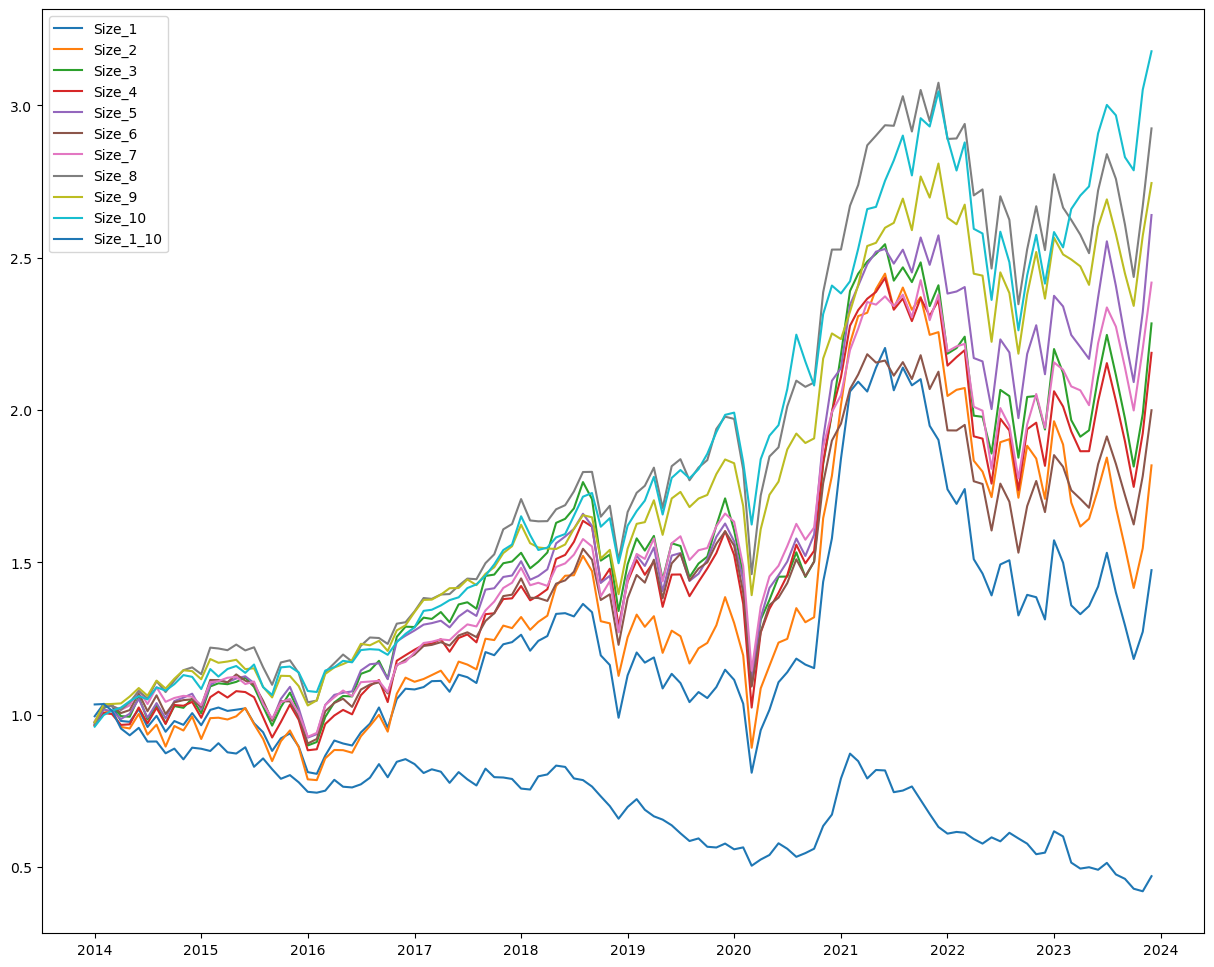

In [37]:
def plot_Size(Size_ret):
    Size_ret_recent = Size_ret[Size_ret['Year']>2013]
    Size_ret_recent['Date'] = pd.to_datetime(Size_ret_recent['Year'].astype(str) + '-' + Size_ret_recent['Month'].astype(str).str.zfill(2))
    Size_ret_recent['Date'] = pd.to_datetime(Size_ret_recent['Date'],format = '%Y%m')
    label_list = np.arange(1,11)
    label_list = np.append(label_list,"1_10")
    plt.figure(figsize = (15,12))
    for i in label_list:
        label_col = f"Size_{i}"
        plt.plot(Size_ret_recent['Date'],(1+Size_ret_recent[label_col]).cumprod(),label = label_col)
    plt.legend()
    plt.show()
    
plot_Size(Size_ret)

C:\Users\14561\AppData\Local\Temp\ipykernel_28748\1052931799.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Size_ret_recent['Date'] = pd.to_datetime(Size_ret_recent['Year'].astype(str) + '-' + Size_ret_recent['Month'].astype(str).str.zfill(2))
C:\Users\14561\AppData\Local\Temp\ipykernel_28748\1052931799.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Size_ret_recent['Date'] = pd.to_datetime(Size_ret_recent['Date'],format = '%Y%m')


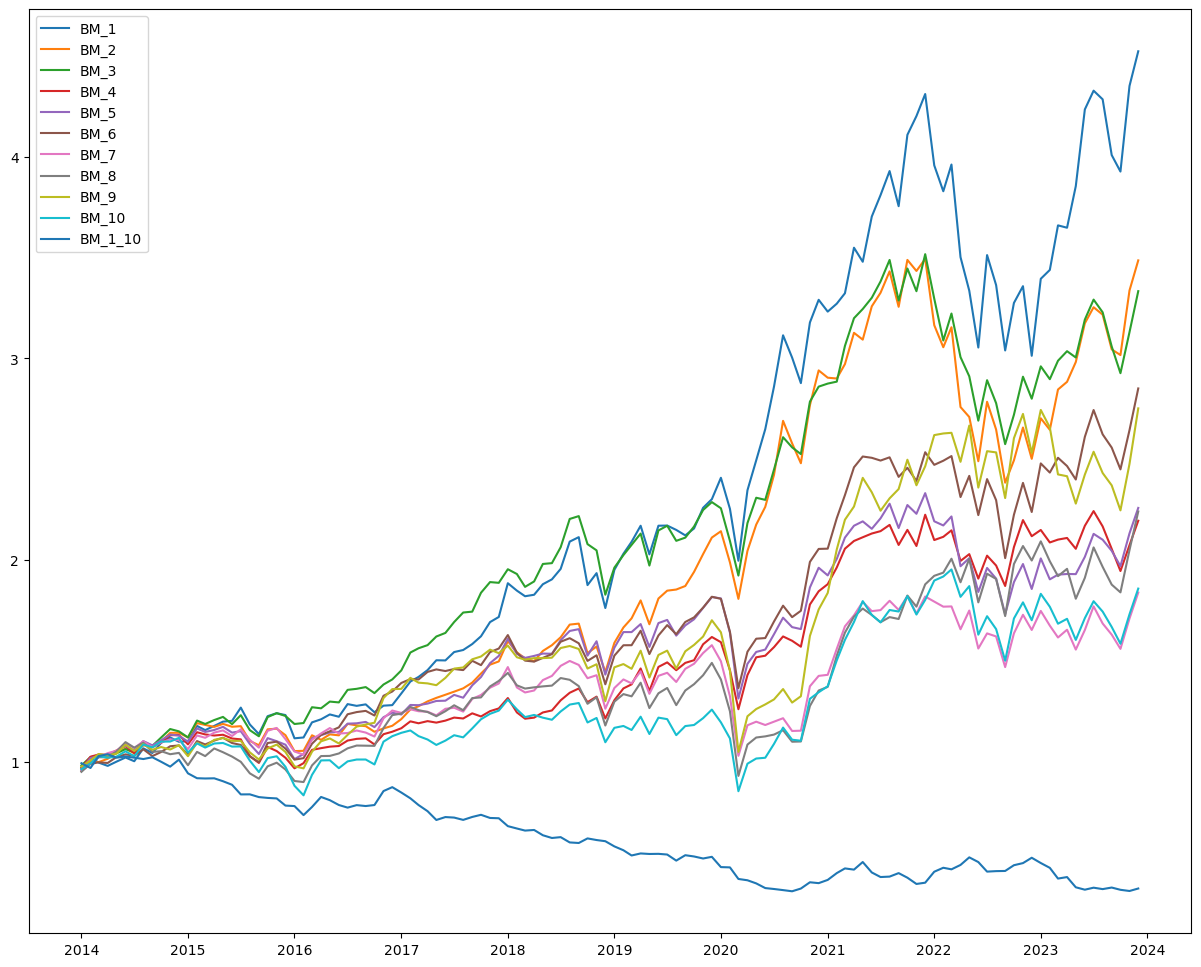

In [38]:
def plot_BM(Size_ret):
    Size_ret_recent = Size_ret[Size_ret['Year']>2013]
    Size_ret_recent['Date'] = pd.to_datetime(Size_ret_recent['Year'].astype(str) + '-' + Size_ret_recent['Month'].astype(str).str.zfill(2))
    Size_ret_recent['Date'] = pd.to_datetime(Size_ret_recent['Date'],format = '%Y%m')
    label_list = np.arange(1,11)
    label_list = np.append(label_list,"1_10")
    plt.figure(figsize = (15,12))
    for i in label_list:
        label_col = f"BM_{i}"
        plt.plot(Size_ret_recent['Date'],(1+Size_ret_recent[label_col]).cumprod(),label = label_col)
    plt.legend()
    plt.show()
    
plot_BM(BM_ret)

### 1993 Paper, SMB and HML

#### 1. load data

In [39]:
crsp_clean = pd.read_pickle('.\data\crsp_linktable_clean.pkl')
FF_data = pd.read_pickle('.\data\\franch.pkl')


FF_data['date'] = pd.to_datetime(FF_data['date'])
FF_data['Year'] = FF_data['date'].dt.year
FF_data['Month'] = FF_data['date'].dt.month

crsp_clean = crsp_clean.merge(FF_data[['Year','Month','RF']],on = ['Year','Month'],how = 'left')
crsp_clean['EX_RET'] = crsp_clean['ret']-crsp_clean['RF']
crsp_clean = crsp_clean[crsp_clean['Year']>=1973]
crsp_clean = crsp_clean[crsp_clean['Year']<=2023]
crsp_clean['BE_ME'] = pd.to_numeric(crsp_clean['BE_ME'] )
crsp_clean['BE_ME'].replace(-np.inf, np.nan, inplace=True)
# drop values where BE is less than 0
crsp_clean['BE'] = np.where(crsp_clean['BE']<0,np.nan,crsp_clean['BE'])
crsp_clean = crsp_clean.dropna(subset = ['BE_ME'])
crsp_clean = crsp_clean.dropna(subset = ['BE'])
crsp_clean


,permno,permco,shrcd,exchcd,siccd,naics,ret,shrout,prc,gvkey,Year,Month,port_Year,BE,ME_raw,ME_12,BE_ME,ME_6,RF,EX_RET
35,10001,7953.0,11.0,3.0,4920.0,None,0.021277,991.0,6.00000,012994,1987,7,1987,7037.0,5.946000e+03,6937.0,1.014415,5.822125e+03,0.0046,0.016677
36,10001,7953.0,11.0,3.0,4920.0,None,0.083333,991.0,6.50000,012994,1987,8,1987,7037.0,6.441500e+03,6937.0,1.014415,5.822125e+03,0.0047,0.078633
37,10001,7953.0,11.0,3.0,4920.0,None,-0.022308,992.0,6.25000,012994,1987,9,1987,7037.0,6.200000e+03,6937.0,1.014415,5.822125e+03,0.0045,-0.026808
38,10001,7953.0,11.0,3.0,4920.0,None,0.020000,992.0,6.37500,012994,1987,10,1987,7037.0,6.324000e+03,6937.0,1.014415,5.822125e+03,0.0060,0.014000
39,10001,7953.0,11.0,3.0,4920.0,None,-0.029412,992.0,6.18750,012994,1987,11,1987,7037.0,6.138000e+03,6937.0,1.014415,5.822125e+03,0.0035,-0.032912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3089284,93436,53453.0,11.0,3.0,9999.0,336110,-0.034962,3173994.0,258.07999,184996,2023,8,2023,44786000.0,8.191443e+08,389741520.0,0.114912,8.308579e+08,0.0045,-0.039462
3089285,93436,53453.0,11.0,3.0,9999.0,336110,-0.030456,3179000.0,250.22000,184996,2023,9,2023,44786000.0,7.954494e+08,389741520.0,0.114912,8.308579e+08,0.0043,-0.034756
3089286,93436,53453.0,11.0,3.0,9999.0,336110,-0.197346,3178921.0,200.84000,184996,2023,10,2023,44786000.0,6.384545e+08,389741520.0,0.114912,8.308579e+08,0.0047,-0.202046
3089287,93436,53453.0,11.0,3.0,9999.0,336110,0.195379,3178921.0,240.08000,184996,2023,11,2023,44786000.0,7.631954e+08,389741520.0,0.114912,8.308579e+08,0.0044,0.190979


#### 2. Create Decile

In [40]:
def decile(df):
    
    for port_Year in df['port_Year'].unique():
        # sub df for July and NYSE
        sub_df = df[(df['port_Year'] == port_Year) & (df['exchcd'] == 1)]
        SMB_breakpoints = pd.qcut(sub_df['ME_6'], 2, labels=False, retbins=True)[1]
        SMB_breakpoints[0] = -np.inf
        SMB_breakpoints[-1] = np.inf

        HML_breakpoints = pd.qcut(sub_df['BE_ME'], [0,0.3,0.7,1.0], labels=False, retbins=True)[1]
        
        HML_breakpoints[0] = -np.inf
        HML_breakpoints[-1] = np.inf
        
        # mask for location to fill decile
        mask = ((df['port_Year'] == port_Year))
        df.loc[mask, 'SMB_decile'] = pd.cut(df.loc[mask, 'ME_6'], bins=SMB_breakpoints, labels=range(1, 3))
        df.loc[mask, 'HML_decile'] = pd.cut(df.loc[mask, 'BE_ME'], bins=HML_breakpoints, labels=range(1,4))
        
    return df

crsp_clean = decile(crsp_clean)      
crsp_clean  

d:\Applications\Anaconda\Lib\site-packages\numpy\lib\function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,permno,permco,shrcd,exchcd,siccd,naics,ret,shrout,prc,gvkey,...,port_Year,BE,ME_raw,ME_12,BE_ME,ME_6,RF,EX_RET,SMB_decile,HML_decile
35,10001,7953.0,11.0,3.0,4920.0,None,0.021277,991.0,6.00000,012994,...,1987,7037.0,5.946000e+03,6937.0,1.014415,5.822125e+03,0.0046,0.016677,1,3
36,10001,7953.0,11.0,3.0,4920.0,None,0.083333,991.0,6.50000,012994,...,1987,7037.0,6.441500e+03,6937.0,1.014415,5.822125e+03,0.0047,0.078633,1,3
37,10001,7953.0,11.0,3.0,4920.0,None,-0.022308,992.0,6.25000,012994,...,1987,7037.0,6.200000e+03,6937.0,1.014415,5.822125e+03,0.0045,-0.026808,1,3
38,10001,7953.0,11.0,3.0,4920.0,None,0.020000,992.0,6.37500,012994,...,1987,7037.0,6.324000e+03,6937.0,1.014415,5.822125e+03,0.0060,0.014000,1,3
39,10001,7953.0,11.0,3.0,4920.0,None,-0.029412,992.0,6.18750,012994,...,1987,7037.0,6.138000e+03,6937.0,1.014415,5.822125e+03,0.0035,-0.032912,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3089284,93436,53453.0,11.0,3.0,9999.0,336110,-0.034962,3173994.0,258.07999,184996,...,2023,44786000.0,8.191443e+08,389741520.0,0.114912,8.308579e+08,0.0045,-0.039462,2,1
3089285,93436,53453.0,11.0,3.0,9999.0,336110,-0.030456,3179000.0,250.22000,184996,...,2023,44786000.0,7.954494e+08,389741520.0,0.114912,8.308579e+08,0.0043,-0.034756,2,1
3089286,93436,53453.0,11.0,3.0,9999.0,336110,-0.197346,3178921.0,200.84000,184996,...,2023,44786000.0,6.384545e+08,389741520.0,0.114912,8.308579e+08,0.0047,-0.202046,2,1
3089287,93436,53453.0,11.0,3.0,9999.0,336110,0.195379,3178921.0,240.08000,184996,...,2023,44786000.0,7.631954e+08,389741520.0,0.114912,8.308579e+08,0.0044,0.190979,2,1


#### 3. Create portfolios

##### 3.1 SMB

In [41]:
crsp_clean['Vw_Ret'] = crsp_clean['ret']*crsp_clean['ME_6']
SMB_ret = crsp_clean.groupby(['Year','Month','SMB_decile'])['Vw_Ret'].sum()/crsp_clean.groupby(['Year','Month','SMB_decile'])['ME_6'].sum()

# Size_ret = crsp_decil.groupby(['Year','Month','Size_decile'])['EX_RET'].mean()

SMB_ret = SMB_ret.unstack(level = 'SMB_decile')
SMB_ret.columns.name = None
SMB_ret.reset_index(inplace=True)
SMB_ret.columns = ['Year', 'Month', 'Small', 'Big']
SMB_ret['SMB'] = SMB_ret['Small']-SMB_ret['Big']
SMB_ret = SMB_ret[SMB_ret['Year']>=1973]
SMB_ret = SMB_ret[SMB_ret['Year']<=2023]
SMB_ret

C:\Users\14561\AppData\Local\Temp\ipykernel_28748\4239121719.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  SMB_ret = crsp_clean.groupby(['Year','Month','SMB_decile'])['Vw_Ret'].sum()/crsp_clean.groupby(['Year','Month','SMB_decile'])['ME_6'].sum()


,Year,Month,Small,Big,SMB
0,1973,1,-0.054073,-0.024536,-0.029537
1,1973,2,-0.081682,-0.039531,-0.042151
2,1973,3,-0.027879,-0.006490,-0.021388
3,1973,4,-0.075162,-0.047959,-0.027203
4,1973,5,-0.087561,-0.021115,-0.066446
...,...,...,...,...,...
607,2023,8,-0.059636,-0.017456,-0.042180
608,2023,9,-0.066583,-0.046617,-0.019966
609,2023,10,-0.075955,-0.023582,-0.052373
610,2023,11,0.103894,0.095307,0.008587


##### 3.2 HML

In [42]:

HML_ret = crsp_clean.groupby(['Year','Month','HML_decile'])['Vw_Ret'].sum()/crsp_clean.groupby(['Year','Month','HML_decile'])['ME_6'].sum()
HML_ret = HML_ret.unstack(level = 'HML_decile')
HML_ret.columns.name = None
HML_ret.reset_index(inplace=True)
HML_ret.columns = ['Year', 'Month', 'Low', 'Mid','High']
HML_ret['HML'] = HML_ret['High']-HML_ret['Low']
HML_ret = HML_ret[HML_ret['Year']>=1973]
HML_ret = HML_ret[HML_ret['Year']<=2023]
HML_ret

C:\Users\14561\AppData\Local\Temp\ipykernel_28748\675409447.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  HML_ret = crsp_clean.groupby(['Year','Month','HML_decile'])['Vw_Ret'].sum()/crsp_clean.groupby(['Year','Month','HML_decile'])['ME_6'].sum()


,Year,Month,Low,Mid,High,HML
0,1973,1,-0.025888,-0.032439,-0.019992,0.005896
1,1973,2,-0.035292,-0.053656,-0.047742,-0.012450
2,1973,3,-0.016641,-0.002069,0.007465,0.024107
3,1973,4,-0.066870,-0.036303,-0.022070,0.044800
4,1973,5,-0.017000,-0.035063,-0.041380,-0.024380
...,...,...,...,...,...,...
607,2023,8,-0.012061,-0.030623,-0.040368,-0.028306
608,2023,9,-0.055474,-0.031490,-0.037612,0.017862
609,2023,10,-0.017448,-0.043309,-0.037353,-0.019905
610,2023,11,0.099888,0.082281,0.105540,0.005652


##### 3.3 FF_data

In [43]:
FF_data = pd.read_pickle('.\data\\franch.pkl')
FF_data['date'] = pd.to_datetime(FF_data['date'])
FF_data['Year'] = FF_data['date'].dt.year
FF_data['Month'] = FF_data['date'].dt.month
FF_data

,date,Mkt-RF,SMB,HML,RF,Mkt,BM01,BM02,BM03,BM04,...,ME4 BM3,ME4 BM4,ME4 BM5,ME5 BM1,ME5 BM2,ME5 BM3,ME5 BM4,ME5 BM5,Year,Month
0,1926-07-31,0.0296,-0.0256,-0.0243,0.0022,0.0318,0.0463,0.0122,0.1138,0.0168,...,0.012978,0.002727,0.024678,0.034539,0.060902,0.020266,0.031111,0.005623,1926,7
1,1926-08-31,0.0264,-0.0117,0.0382,0.0025,0.0289,0.0015,0.0219,0.0639,0.0238,...,0.020021,0.021706,0.053422,0.010124,0.041903,0.020131,0.054849,0.077576,1926,8
2,1926-09-30,0.0036,-0.0140,0.0013,0.0023,0.0059,-0.0011,-0.0232,0.0630,0.0073,...,-0.017636,0.014646,0.008730,-0.012906,0.036538,0.000950,-0.007487,-0.024284,1926,9
3,1926-10-31,-0.0324,-0.0009,0.0070,0.0032,-0.0292,-0.0378,-0.0167,-0.0501,-0.0141,...,-0.021070,-0.031051,-0.053525,-0.027413,-0.030071,-0.022437,-0.046719,-0.058129,1926,10
4,1926-11-30,0.0253,-0.0010,-0.0051,0.0031,0.0284,0.0603,0.0151,0.0110,0.0363,...,0.037335,0.049320,0.018213,0.042946,0.025326,0.015204,0.036619,0.025636,1926,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,2023-11-30,0.0884,-0.0002,0.0164,0.0044,0.0928,0.1108,0.0758,0.0757,0.0714,...,0.095279,0.087238,0.078476,0.098946,0.070176,0.070932,0.086614,0.152510,2023,11
1169,2023-12-31,0.0487,0.0634,0.0493,0.0043,0.0530,0.0363,0.0507,0.0586,0.0590,...,0.091821,0.090094,0.117210,0.037289,0.047129,0.050839,0.046592,0.116076,2023,12
1170,2024-01-31,0.0071,-0.0509,-0.0238,0.0047,0.0118,0.0229,0.0128,-0.0023,-0.0176,...,-0.015281,-0.032800,-0.024467,0.022795,-0.005613,0.035883,0.026630,-0.008891,2024,1
1171,2024-02-29,0.0506,-0.0024,-0.0349,0.0042,0.0548,0.0592,0.0646,0.0252,0.0425,...,0.033699,0.046102,0.025429,0.060660,0.016357,0.080426,0.049935,0.029089,2024,2


In [44]:
FF_data = FF_data[(FF_data['Year']>=1973) &(FF_data['Year']<=2023)]
FF_SMB = FF_data[['Year','Month','SMB']].copy()
FF_HML = FF_data[['Year','Month','HML']].copy()
FF_SMB

,Year,Month,SMB
558,1973,1,-0.0349
559,1973,2,-0.0387
560,1973,3,-0.0282
561,1973,4,-0.0385
562,1973,5,-0.0630
...,...,...,...
1165,2023,8,-0.0316
1166,2023,9,-0.0251
1167,2023,10,-0.0388
1168,2023,11,-0.0002


#### 4. Output

In [45]:
def SMB_NML_output(SMB_ret,HML_ret,FF_SMB,FF_HML):
    result = pd.DataFrame()
    
    HML_FF = FF_HML['HML']
    SMB_FF = FF_SMB['SMB']
    
    HML = HML_ret['HML']
    SMB = SMB_ret['SMB']
        
    result.loc['FF-Excess Return','HML'] = ex_ret(HML_FF)
    result.loc['FF-Volatility','HML'] = std(HML_FF)
    result.loc['FF-Sharpe Ratio','HML'] = SR(HML_FF)
    result.loc['FF-Skewness','HML'] = np.round(skew(HML_FF),2)
    
    result.loc['-','HML'] = '--'
    
    result.loc['Excess Return','HML'] = ex_ret(HML)
    result.loc['Volatility','HML'] = std(HML)
    result.loc['Sharpe Ratio','HML'] = SR(HML)
    result.loc['Skewness','HML'] = np.round(skew(HML),2)
    
    result.loc['corr w/original','HML'] =np.round(np.corrcoef(HML,HML_FF)[0, 1],4)
    
    result.loc['FF-Excess Return','SMB'] = ex_ret(SMB_FF)
    result.loc['FF-Volatility','SMB'] = std(SMB_FF)
    result.loc['FF-Sharpe Ratio','SMB'] = SR(SMB_FF)
    result.loc['FF-Skewness','SMB'] = np.round(skew(SMB_FF),2)
    
    result.loc['-','SMB'] = '--'
    
    result.loc['Excess Return','SMB'] = ex_ret(SMB)
    result.loc['Volatility','SMB'] = std(SMB)
    result.loc['Sharpe Ratio','SMB'] = SR(SMB)
    result.loc['Skewness','SMB'] = np.round(skew(SMB),2)
    
    result.loc['corr w/original','SMB'] =np.round(np.corrcoef(SMB,SMB_FF)[0, 1],4)
        

        

    return result

output = SMB_NML_output(SMB_ret,HML_ret,FF_SMB,FF_HML)
output

C:\Users\14561\AppData\Local\Temp\ipykernel_28748\3092065629.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '--' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  result.loc['-','HML'] = '--'
C:\Users\14561\AppData\Local\Temp\ipykernel_28748\3092065629.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '--' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  result.loc['-','SMB'] = '--'


,HML,SMB
FF-Excess Return,3.58,1.73
FF-Volatility,10.82,10.59
FF-Sharpe Ratio,0.33,0.16
FF-Skewness,0.07,0.46
-,--,--
Excess Return,3.12,2.1
Volatility,11.79,11.14
Sharpe Ratio,0.26,0.19
Skewness,0.19,0.41
corr w/original,0.8817,0.9292
